In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from itertools import chain
import glob
import seaborn as sns
import matplotlib.font_manager as font_manager
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from collections import Counter
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
import warnings
import itertools
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
register_matplotlib_converters()

In [2]:
sns.set_theme()
mpl.matplotlib_fname()
font_dirs = ['D:\\Software\\Anaconda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf' ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
mpl.font_manager._rebuild()
result = font_manager.findfont("Rounded Mplus 1c")
print(result)
mpl.rc('font', family='Rounded Mplus 1c')

D:\Software\Anaconda\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\MPLUSRounded1c-Regular.ttf


In [3]:
def extract_engine_data (description, list_em):
    engine_model = []
    for e in list_em:
        em_reg = re.findall(r'\b{}-\w+-?\w*\b'.format(e), description)
        if len(em_reg) != 0 :
          em_reg = map(lambda x : x.split('-')[0],em_reg)
#           em_reg = list(set(em_reg)) 
          engine_model.append(em_reg)
    if len(engine_model) != 0:
      return list(chain(*engine_model))
    else: 
      return 0

def normalize_zero (row,unit_price):
    if row['Quantity'] == 0:
      if row['Cargo Value USD'] % unit_price < 2:
        return 1
      else:
        return row['Cargo Value USD'] // unit_price
    else:
        return row['Quantity']
    

def check_count_em (row,unit_price):
    if (row['count_em'] == 1) and (row['len_em'] > 1):
       if (row['Cargo Value USD'] < unit_price) or (row['Cargo Value USD'] == unit_price):
         return  round(row['Cargo Value USD']/row['len_em'],2)
       else:
         return unit_price

    elif (row['count_em'] > 1) and (row['len_em'] > 1):
        if (row['Cargo Value USD'] < row['count_em'] * unit_price) or (row['Cargo Value USD'] == row['count_em'] * unit_price):
           return  round(row['Cargo Value USD']/row['Quantity'],2)
#         elif row['Cargo Value USD'] > row['count_em'] * 266.77
#              return  round(row['Cargo Value USD']/row['len_em'],2)
        else:
            return row['count_em'] * unit_price
#             return  round(row['Cargo Value USD']/row['Quantity']*row['count_em'],2)
    elif ((row['count_em'] ==1) and (row['len_em'] == 1)):
       return  round(row['Cargo Value USD']/row['len_em'],2)
    else:
       return row['Cargo Value USD']



def count_length(list_em,em):
    count  = 0
    for i in list_em:
        if i == em:
            count+=1
    return count

In [4]:
# Load list all engine model in GTO
# df_merged = read_csv('list_all_em_GTO.csv',parse_dates=['Register Date'])
df_merged = read_csv('list_all_em_GTO.csv')
df_merged['Register Date'] = pd.to_datetime(df_merged['Register Date'],format='%Y-%m-%d')
df_merged.drop('Unnamed: 0',axis=1,inplace=True)
df_merged.head()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64
2,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,БЕНЗИНОВЫЙ,ОБЪЕМ 6000СМ.КУБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",30,ШТ,CPT,14400.0,14400.0,27000.00
3,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,НЕКОМПЛЕКТНЫЙ,БЕНЗИНОВЫЙ,ОБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",15,ШТ,CPT,3000.0,3000.0,6894.50
4,2011-01-20,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ В СБОРЕ С КОРОБКОЙ ПЕРЕДА...,MERCEDES - BENZ,MERCEDES - BENZ,ТОЯМА НЬЮ ПОРТ,"JP, JPN, Japan","JP, JPN, Japan","METAL AUTO HOKURIKU CO., LTD","ISHIKAWA KEN KOMATSU SHI SHIRAE MACHI, RO 62",ИП КОЧЕТКОВ ВЯЧЕСЛАВ ВИКТОРОВИЧ,"664019, , Г ИРКУТСК, ПЕР. МИНУСИНСКИЙ Д 10",38,ШТ,FOB,6460.0,6460.0,6536.45


In [5]:
for col in list(df_merged.columns):
 (df_merged[col].dtype ==  'object') and (df_merged[col].fillna(value='unknown',inplace = True)) or (df_merged[col].fillna(value=0, inplace = True))

In [6]:
# Load list engine model
df_list_engine = pd.read_excel('Engine Model _1025.xlsx')
df_list_engine.head()

,Unnamed: 0,メーカー,燃料,買付受付,型式,駆動1,駆動2,駆動3,詳細,車輌型式,KRA売単価,車名,仕入値,EG売価\n（マニ触付）\nW,EG売価\n（マニ触抜/無）\nWO
0,2.0,FIAT,0,×,4,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,売価確認
1,3.0,PORCHE,NaN,×,64,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
2,4.0,PORCHE,NaN,×,66,RR,MT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
3,5.0,PORCHE,NaN,×,70,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
4,6.0,BENZ,NaN,○,102,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,40000,0


In [7]:
# Load list engine TOYOTA
df_brand_toyota =  df_list_engine[df_list_engine['メーカー']  == 'TOYOTA']
list_toyota = list(df_brand_toyota['型式'].unique())
list_toyota  = list(map(lambda x: x.split('-')[0],list_toyota))
list_toyota  = list(set(list_toyota))

In [8]:
df_brand_mazda =  df_list_engine[df_list_engine['メーカー']  == 'MAZDA']
list_mazda = list(df_brand_mazda['型式'].unique())
list_mazda  = list(map(lambda x: x.split('-')[0],list_mazda))
list_mazda  = list(set(list_mazda))

In [9]:
df_brand_mitsubishi =  df_list_engine[df_list_engine['メーカー']  == 'MITSUBISHI']
list_mitsubishi = list(df_brand_mitsubishi['型式'].unique())
list_mitsubishi  = list(map(lambda x: x.split('-')[0],list_mitsubishi))
list_mitsubishi  = list(set(list_mitsubishi))

In [10]:
df_brand_honda =  df_list_engine[df_list_engine['メーカー']  == 'HONDA']
list_honda = list(df_brand_honda['型式'].unique())
list_honda  = list(map(lambda x: x.split('-')[0],list_honda))
list_honda  = list(set(list_honda))

In [11]:
df_brand_nissan =  df_list_engine[df_list_engine['メーカー']  == 'NISSAN']
list_nissan = list(df_brand_nissan['型式'].unique())
list_nissan  = list(map(lambda x: x.split('-')[0],list_nissan))
list_nissan  = list(set(list_nissan))

In [12]:
df_brand_subaru =  df_list_engine[df_list_engine['メーカー']  == 'SUBARU']
list_subaru = list(df_brand_subaru['型式'].unique())
list_subaru  = list(map(lambda x: x.split('-')[0],list_subaru))
list_subaru  = list(set(list_subaru))

# Extract list engine of each brand

In [13]:
df_toyota_GTO = df_merged[df_merged.Producer.str.contains('TOYOTA')]
df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
df_toyota_GTO['brand'] = 'TOYOTA'
df_toyota_GTO_extracted_em = df_toyota_GTO[df_toyota_GTO['extracted_engine'] !=0]

<ipython-input-13-2c10ef0cfc14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
<ipython-input-13-2c10ef0cfc14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['brand'] = 'TOYOTA'


In [14]:
df_mazda_GTO = df_merged[df_merged.Producer.str.contains('MAZDA')]
df_mazda_GTO['brand'] = 'MAZDA'
df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))
df_mazda_GTO_extracted_em = df_mazda_GTO[df_mazda_GTO['extracted_engine'] !=0]

<ipython-input-14-55b0c9e7ffc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['brand'] = 'MAZDA'
<ipython-input-14-55b0c9e7ffc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))


In [15]:
df_mitsubishi_GTO = df_merged[df_merged.Producer.str.contains('MITSUBISHI')]
df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))
df_mitsubishi_GTO_extracted_em = df_mitsubishi_GTO[df_mitsubishi_GTO['extracted_engine'] !=0]

<ipython-input-15-a3695c5d34da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
<ipython-input-15-a3695c5d34da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))


In [16]:
df_mitsubishi_GTO_extracted_em

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,brand,extracted_engine
12,2011-01-18,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD","614-8051 КЙОТО ЯВАТА-СИТИ ЯВАТА-ЯМАДА, 67-3",ИП КАРПЕНОК НАТАЛЬЯ ГЕННАДЬЕВНА,"690105, ПРИМОРСКИЙ КРАЙ, Г. ВЛАДИВОСТОК, УЛ. Р...",22,ШТ,FOB,5500.0,5500.0,3339.77,MITSUBISHI,[4G93]
22,2011-01-27,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD","614-8051 КЙОТО ЯВАТА-СИТИ ЯВАТА-ЯМАДА, 67-3",КАРПЕНОК НАТАЛЬЯ ГЕНАДЬЕВНА ПАСПОРТ 0503№28165...,"690105, ПРИМОРСКИЙ КРАЙ, ВЛАДИВОСТОК, РУССКАЯ ...",19,ШТ,FOB,4750.0,4750.0,2867.72,MITSUBISHI,"[6G73, 6G73]"
45,2011-01-13,8407343009,"ДВИГАТЕЛЬ БЕНЗИН.ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА В СБ...","NISSAN, MITSUBISHI,TOYOTA,MAZDA,HONDA,SUBARU,D...","NISSAN, MITSUBISHI, TOYOTA,MAZDA,SUBARU,HONDA,...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LEEA CORPORATION,"HIROSHIMA TAKAYADAI 2-CHOME, 1-8",ООО РДС-АВТО,"690066, ПРИМОРСКИЙ КРАЙ, ВЛАДИВОСТОК, УЛ.ШИЛКИ...",35,ШТ,CFR,10255.0,10255.0,6160.00,MITSUBISHI,[4G93]
55,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIKARI SYOJI CO.,LTD","KYOTO YAWATA-CITY 27, YAWATAKUBOTA",САКУРА МОТОРС КЕМЕРОВО ООО,"650010, КЕМЕРОВСКАЯ ОБЛАСТЬ, КЕМЕРОВО, МАЯКОВС...",34,ШТ,CFR,7235.0,7235.0,3945.00,MITSUBISHI,[4G93]
91,2011-01-21,8407343009,"ЗАП.ЧАСТИ ДЛЯ А/М, Б/У ДВИГАТЕЛЯ С АКП ЯПОНСКО...","TOYOTA,MITSUBISHI,SUBARU","TOYOTA,MITSUBISHI,SUBARU",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","АВТОЛОМ ДЖАПАН КО.,ЛТД","17-1 ДЖАПАН ПУСАН НИШИДЕГУЧИ,АЗА 16 ХАСУГАУРА,...",ООО ДВ-МОТОРС,"690065, ПРИМОРСКИЙ КРАЙ, Г. ВЛАДИВОСТОК, УЛ. С...",3,ШТ,CFR,600.0,600.0,480.00,MITSUBISHI,[4G15]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,"920-0209, ISHIKAWA KEN, KANAZAWA-SHI, 1-25 HIG...",ООО АВТОСТОК,"630088, ГОРОД НОВОСИБИРСК, СЕВЕРНЫЙ ПРОЕЗД, Д ...",0,unknown,FOB,2125.0,2070.0,3133.66,MITSUBISHI,"[4G93, 4G94]"
259055,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,"ЯПОНИЯ, ЙОКОГАМА, АСОНА, БИЗИН 926-3",ИП МАТВЕЕВ СТАНИСЛАВ ВАЛЕРЬЕВИЧ,"630000, ГОРОД НОВОСИБИРСК",0,unknown,CFR,467.0,467.0,706.00,MITSUBISHI,[4G93]
259068,2019-12-01,8407343009,ДВИГАТЕЛИ-2ШТ.БЫВШ.В УПОТР.КАРБЮРАТ.ОБЪЕМ 1834...,MITSUBISHI MOTOR CO.,MITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,"KIYOSE-CITY, TOKYO, 6-95-1-105 NAKAZATO",ИП ФОМИЧЕВ АЛЕКСАНДР ИВАНОВИЧ,"630000, ГОРОД НОВОСИБИРСК",0,unknown,CFR,460.0,460.0,720.70,MITSUBISHI,"[4G93, 4G63]"
259138,2019-12-01,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,FUJI HEAVY INDUSTRIES CO.LTDMITSUBISHI MOTORS ...,SUBARUMITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",WEST-JAPAN AUTO RECYCLE CO.LTD (WARC),"1-62, FUKUOKA, KITAKYUSHU, HIBIKIMACHI, WAKAMA...",ООО ПАРУС,"650040, 650040, ОБЛАСТЬ КЕМЕРОВСКАЯ ОБЛАСТЬ - ...",0,unknown,CFR,760.0,760.0,1148.61,MITSUBISHI,[6G73]


In [17]:
df_honda_GTO = df_merged[df_merged.Producer.str.contains('HONDA')]
df_honda_GTO['brand'] = 'HONDA'
df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))
df_honda_GTO_extracted_em = df_honda_GTO[df_honda_GTO['extracted_engine'] !=0]

<ipython-input-17-0c8c0f52b4a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['brand'] = 'HONDA'
<ipython-input-17-0c8c0f52b4a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))


In [18]:
df_nissan_GTO = df_merged[df_merged.Producer.str.contains('NISSAN')]
df_nissan_GTO['brand'] = 'NISSAN'
df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))
df_nissan_GTO_extracted_em = df_nissan_GTO[df_nissan_GTO['extracted_engine'] !=0]

<ipython-input-18-edd9724bdd48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['brand'] = 'NISSAN'
<ipython-input-18-edd9724bdd48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))


In [19]:
df_subaru_GTO = df_merged[df_merged.Producer.str.contains('SUBARU')]
df_subaru_GTO['brand'] = 'SUBARU'
df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))
df_subaru_GTO_extracted_em = df_subaru_GTO[df_subaru_GTO['extracted_engine'] != 0]

<ipython-input-19-72adf53e9231>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['brand'] = 'SUBARU'
<ipython-input-19-72adf53e9231>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))


In [20]:
list_brand  = [df_toyota_GTO_extracted_em,df_mazda_GTO_extracted_em,df_mitsubishi_GTO_extracted_em,df_honda_GTO_extracted_em,df_nissan_GTO_extracted_em,df_subaru_GTO_extracted_em]
df_all = pd.concat(list_brand)

In [21]:
df_all['extracted_engine'] = df_all.extracted_engine.map(tuple)
df_all.drop_duplicates()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36,"(2TR, 2TR)",TOYOTA
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64,"(2TR, 2TR)",TOYOTA
6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",1,ШТ,CFR,150.0,150.0,120.00,"(1JZ,)",TOYOTA
10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(2UZ, 2TR, 5K)",TOYOTA
11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(2UZ, 2TR, 5K)",TOYOTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258909,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,"875-1, KAMONOFU, SINGU, FUKUOKA PREF, KASUYA",ООО КАСТОМ-ВЛ,"690003, ГОРОД ВЛАДИВОСТОК, УЛ НИЖНЕПОРТОВАЯ, Д...",0,unknown,CFR,220.0,220.0,332.20,"(EJ20,)",SUBARU
258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,"920-0209, ISHIKAWA KEN, KANAZAWA-SHI, 1-25 HIG...",ООО АВТОСТОК,"630088, ГОРОД НОВОСИБИРСК, СЕВЕРНЫЙ ПРОЕЗД, Д ...",0,unknown,FOB,2125.0,2070.0,3133.66,"(EJ15,)",SUBARU


In [22]:
df_all['extracted_engine'] = df_all.extracted_engine.map(list)

In [23]:
df_copy = df_all.copy().reset_index()
df_copy['month_year'] = df_copy['Register Date'].dt.strftime('%Y-%m')
df_copy['year'] =  df_copy['Register Date'].dt.strftime('%Y')
df_copy['len_unique_em'] = df_copy['extracted_engine'].map(lambda x : len(set(x)))
df_copy['len_em'] = df_copy['extracted_engine'].map(lambda x : len(x))
df_copy

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
0,0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,CIF,3604.0,3017.0,73063.36,"[2TR, 2TR]",TOYOTA,2011-01,2011,1,2
1,1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,CIF,1765.0,1465.0,37014.64,"[2TR, 2TR]",TOYOTA,2011-01,2011,1,2
2,6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,150.0,150.0,120.00,[1JZ],TOYOTA,2011-01,2011,1,1
3,10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,450.0,450.0,360.00,"[2UZ, 2TR, 5K]",TOYOTA,2011-01,2011,3,3
4,11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,450.0,450.0,360.00,"[2UZ, 2TR, 5K]",TOYOTA,2011-01,2011,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43878,258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,CFR,200.0,200.0,302.00,[EJ20],SUBARU,2019-12,2019,1,1
43879,258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,...,CFR,220.0,220.0,332.20,[EJ20],SUBARU,2019-12,2019,1,1
43880,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,FOB,2125.0,2070.0,3133.66,[EJ15],SUBARU,2019-12,2019,1,1
43881,259059,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",SUBARU DAIHATSU,SUBARU DAIHATSU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,CFR,383.0,383.0,578.00,[FB20],SUBARU,2019-12,2019,1,1


In [24]:
df_copy[df_copy.brand == 'MITSUBISHI']

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
24123,12,2011-01-18,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD",...,FOB,5500.0,5500.0,3339.77,[4G93],MITSUBISHI,2011-01,2011,1,1
24124,22,2011-01-27,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD",...,FOB,4750.0,4750.0,2867.72,"[6G73, 6G73]",MITSUBISHI,2011-01,2011,1,2
24125,45,2011-01-13,8407343009,"ДВИГАТЕЛЬ БЕНЗИН.ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА В СБ...","NISSAN, MITSUBISHI,TOYOTA,MAZDA,HONDA,SUBARU,D...","NISSAN, MITSUBISHI, TOYOTA,MAZDA,SUBARU,HONDA,...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LEEA CORPORATION,...,CFR,10255.0,10255.0,6160.00,[4G93],MITSUBISHI,2011-01,2011,1,1
24126,55,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIKARI SYOJI CO.,LTD",...,CFR,7235.0,7235.0,3945.00,[4G93],MITSUBISHI,2011-01,2011,1,1
24127,91,2011-01-21,8407343009,"ЗАП.ЧАСТИ ДЛЯ А/М, Б/У ДВИГАТЕЛЯ С АКП ЯПОНСКО...","TOYOTA,MITSUBISHI,SUBARU","TOYOTA,MITSUBISHI,SUBARU",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","АВТОЛОМ ДЖАПАН КО.,ЛТД",...,CFR,600.0,600.0,480.00,[4G15],MITSUBISHI,2011-01,2011,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30275,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,FOB,2125.0,2070.0,3133.66,"[4G93, 4G94]",MITSUBISHI,2019-12,2019,2,2
30276,259055,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,CFR,467.0,467.0,706.00,[4G93],MITSUBISHI,2019-12,2019,1,1
30277,259068,2019-12-01,8407343009,ДВИГАТЕЛИ-2ШТ.БЫВШ.В УПОТР.КАРБЮРАТ.ОБЪЕМ 1834...,MITSUBISHI MOTOR CO.,MITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,...,CFR,460.0,460.0,720.70,"[4G93, 4G63]",MITSUBISHI,2019-12,2019,2,2
30278,259138,2019-12-01,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,FUJI HEAVY INDUSTRIES CO.LTDMITSUBISHI MOTORS ...,SUBARUMITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",WEST-JAPAN AUTO RECYCLE CO.LTD (WARC),...,CFR,760.0,760.0,1148.61,[6G73],MITSUBISHI,2019-12,2019,1,1


In [27]:
#       B20B	4431	16.59
# 21	F23A	2681	10.04
# 10	D15B	2577	9.65
# 33	L13A	2443	9.15
# 11	D16A	2025	7.58


SyntaxError: invalid syntax (<ipython-input-27-1ec05c1b6381>, line 8)

In [30]:
%%javascript
if (!Jupyter.toolbar.actions.get('cellfreezer:freeze')) {
    Jupyter.toolbar.actions.register({
      icon: 'fa-thumb-tack',
      handler: function() {
        var cell = Jupyter.notebook.get_selected_cell().element[0];
        if (!cell.style.position) {
          cell.style.position = 'fixed';
          cell.style.top = '0px';
          cell.style.left = '0px';
          cell.style['z-index'] = 999;
          cell.style.background = 'rgba(234, 211, 146, 0.88)';
          cell.style.width = '50%';
        } else {
          cell.style.position = '';
          cell.style.top = '';
          cell.style.left = '';
          cell.style['z-index'] = '';
          cell.style.background = '';
          cell.style.width = '';
        }
      }
    }, 'freeze', 'cellfreezer');
    Jupyter.toolbar.add_buttons_group(['cellfreezer:freeze']);
    Jupyter.keyboard_manager.command_shortcuts.add_shortcut('q', 'cellfreezer:freeze');
}

<IPython.core.display.Javascript object>

# NISSAN: EM =  RB20

In [33]:
# df_copy.extracted_engine.map(list)
df_3s  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'RB20' in x)]
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
39155,996,2011-01-21,8407343009,ДВИГАТЕЛИ БЕНЗ.С НАВЕСНЫМ ОБОРУД.БЫВШ.В УПОТР....,"TOYOTA MOTOR CORP., NISSAN MOTOR COMP., HONDA ...","TOYOTA, NISSAN, HONDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",HASEGAWA MOTOR COMPANY LTD.,...,CFR,2180.0,2180.0,2230.00,[RB20],NISSAN,2011-01,2011,1,1
39161,2688,2011-02-25,8407343009,ДВИГ БEНЗ ДЛЯ A/М МACC МEНEE 3 5 Т C К/П БЫВШ ...,"TOYOTA MOTOR CORPORATION СМ.ДОПОЛНЕНИЕ, TOYOTA...","TOYOTA,HONDA,NISSAN,MAZDA,SUZUKI",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",HIRANUMASHOKAI,...,CFR,4840.0,4840.0,2640.00,[RB20],NISSAN,2011-02,2011,1,1
39162,3064,2011-03-01,8407343009,ДВИГАТЕЛЬ КАРБЮРАТОР БЫВ.В УПОТР.ОТДЕЛЬНО И В ...,HONDA MOTOR CO.LTD;MMC MOTORS;NISSAN MOTOR CO....,":HONDA,MMC,NISSAN,SUBARU,MAZDA,DAIHATSU;",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","ECO-R CO.LTD,838-1 KUBOTA,ASHIKAGA,TOCHIGI,",...,CFR,3801.6,3801.6,3162.86,[RB20],NISSAN,2011-03,2011,1,1
39163,3070,2011-03-03,8407343009,ДВИГАТЕЛИ КАРБ.БЫВШ.В УП.В СБОРЕ С НАВЕСНЫМ ОБ...,"TOYOTA MOTOR CORPORATION,NISSAN MOTOR CO.,LTD,...","TOYOTA,NISSAN,HONDA,SUBARU,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","O.M.AUTO.,LTD NISHIKI-MATI 5-1 MINATO-KU NAGOY...",...,CFR,5110.6,5110.6,3416.36,[RB20],NISSAN,2011-03,2011,1,1
39165,4587,2011-03-25,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"TOYOTA MOTOR CORPORATION,NISSAN MOTOR CO.,LTD,...","TOYOTA,MITSUBISHI,SUBARU,NISSAN",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",GPRSERVICE INCORPORATED HONMOKUCHO 1-51 NAKA-K...,...,CFR,2435.4,2435.4,2197.80,[RB20],NISSAN,2011-03,2011,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40107,251844,2019-11-01,8407343009,"ДВИГАТЕЛИ БЕНЗИНОВЫЕ БЫВШИЕ В УПОТРЕБЛЕНИИ, В ...",NISSAN MOTOR CO. LTD.,NISSAN,HAKATA,JAPAN,JAPAN,AL EXPORT,...,FOB,940.0,940.0,1424.82,[RB20],NISSAN,2019-11,2019,1,1
40108,252046,2019-11-01,8407343009,"ДВИГАТЕЛИ-6ШТ,БЫВШ.В УПОТР.КАРБЮРАТ.ОБЪЕМ 1497...",NISSAN MOTOR CO.,NISSAN,ВОСТОЧНЫЙ,JAPAN,JAPAN,TRIDENT CO. LTD.,...,CFR,1800.0,1800.0,2758.77,[RB20],NISSAN,2019-11,2019,1,1
40109,252350,2019-11-01,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М БЕЗ АКП, T.M.N...",NISSAN,NISSAN,ВЛАДИВОСТОК,JAPAN,JAPAN,ASTRADE CO.LTD,...,CFR,740.0,740.0,1110.00,[RB20],NISSAN,2019-11,2019,1,1
40110,253007,2019-11-01,8407343009,"ДВИГАТЕЛИ ВНУТРЕН, СГОРАНИЯ С ИСКР. ЗАЖИГ, БЕН...",NISSAN,NISSAN,ВЛАДИВОСТОК,JAPAN,JAPAN,SAKODA SHOTEN,...,CFR,5495.0,5495.0,8297.45,"[RB20, RB20]",NISSAN,2019-11,2019,1,2


In [34]:
df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length(x,'RB20') )

<ipython-input-34-83eb82b6bc0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length(x,'RB20') )


In [35]:
unit_price = df_3s[(df_3s.Quantity == 1) & (df_3s.count_em==1)].describe().loc[('mean','Cargo Value USD')]
unit_price

260.8364285714286

In [36]:
df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)

<ipython-input-36-138da5abc9fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)


In [37]:
df_3s.describe()

,index,HS Code,Quantity,Gross Weight in KG,Net Weight in KG,Cargo Value USD,len_unique_em,len_em,count_em
count,463.000000,4.630000e+02,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000
mean,101585.365011,8.407343e+09,8.606911,1756.182937,1756.157019,2241.576350,1.025918,1.138229,1.112311
std,69826.248412,0.000000e+00,7.440159,1438.521887,1438.551538,1874.294515,0.159062,0.413917,0.354806
min,996.000000,8.407343e+09,1.000000,120.000000,108.000000,50.000000,1.000000,1.000000,1.000000
25%,46155.000000,8.407343e+09,4.000000,750.000000,750.000000,914.325000,1.000000,1.000000,1.000000
50%,82755.000000,8.407343e+09,7.000000,1380.000000,1380.000000,1790.330000,1.000000,1.000000,1.000000
75%,136046.000000,8.407343e+09,11.000000,2295.000000,2295.000000,3007.105000,1.000000,1.000000,1.000000
max,257755.000000,8.407343e+09,68.000000,10940.000000,10940.000000,13633.130000,2.000000,5.000000,4.000000


In [38]:
df_3s['total_price'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)
# df_3s.drop(columns = ['total_price_1nz'],inplace = True)

<ipython-input-38-097b22d29e78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['total_price'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)


In [39]:
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em,count_em,total_price
39155,996,2011-01-21,8407343009,ДВИГАТЕЛИ БЕНЗ.С НАВЕСНЫМ ОБОРУД.БЫВШ.В УПОТР....,"TOYOTA MOTOR CORP., NISSAN MOTOR COMP., HONDA ...","TOYOTA, NISSAN, HONDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",HASEGAWA MOTOR COMPANY LTD.,...,2180.0,2230.00,[RB20],NISSAN,2011-01,2011,1,1,1,2230.000000
39161,2688,2011-02-25,8407343009,ДВИГ БEНЗ ДЛЯ A/М МACC МEНEE 3 5 Т C К/П БЫВШ ...,"TOYOTA MOTOR CORPORATION СМ.ДОПОЛНЕНИЕ, TOYOTA...","TOYOTA,HONDA,NISSAN,MAZDA,SUZUKI",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",HIRANUMASHOKAI,...,4840.0,2640.00,[RB20],NISSAN,2011-02,2011,1,1,1,2640.000000
39162,3064,2011-03-01,8407343009,ДВИГАТЕЛЬ КАРБЮРАТОР БЫВ.В УПОТР.ОТДЕЛЬНО И В ...,HONDA MOTOR CO.LTD;MMC MOTORS;NISSAN MOTOR CO....,":HONDA,MMC,NISSAN,SUBARU,MAZDA,DAIHATSU;",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","ECO-R CO.LTD,838-1 KUBOTA,ASHIKAGA,TOCHIGI,",...,3801.6,3162.86,[RB20],NISSAN,2011-03,2011,1,1,1,3162.860000
39163,3070,2011-03-03,8407343009,ДВИГАТЕЛИ КАРБ.БЫВШ.В УП.В СБОРЕ С НАВЕСНЫМ ОБ...,"TOYOTA MOTOR CORPORATION,NISSAN MOTOR CO.,LTD,...","TOYOTA,NISSAN,HONDA,SUBARU,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","O.M.AUTO.,LTD NISHIKI-MATI 5-1 MINATO-KU NAGOY...",...,5110.6,3416.36,[RB20],NISSAN,2011-03,2011,1,1,1,3416.360000
39165,4587,2011-03-25,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"TOYOTA MOTOR CORPORATION,NISSAN MOTOR CO.,LTD,...","TOYOTA,MITSUBISHI,SUBARU,NISSAN",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",GPRSERVICE INCORPORATED HONMOKUCHO 1-51 NAKA-K...,...,2435.4,2197.80,[RB20],NISSAN,2011-03,2011,1,1,1,2197.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40107,251844,2019-11-01,8407343009,"ДВИГАТЕЛИ БЕНЗИНОВЫЕ БЫВШИЕ В УПОТРЕБЛЕНИИ, В ...",NISSAN MOTOR CO. LTD.,NISSAN,HAKATA,JAPAN,JAPAN,AL EXPORT,...,940.0,1424.82,[RB20],NISSAN,2019-11,2019,1,1,1,1424.820000
40108,252046,2019-11-01,8407343009,"ДВИГАТЕЛИ-6ШТ,БЫВШ.В УПОТР.КАРБЮРАТ.ОБЪЕМ 1497...",NISSAN MOTOR CO.,NISSAN,ВОСТОЧНЫЙ,JAPAN,JAPAN,TRIDENT CO. LTD.,...,1800.0,2758.77,[RB20],NISSAN,2019-11,2019,1,1,1,2758.770000
40109,252350,2019-11-01,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М БЕЗ АКП, T.M.N...",NISSAN,NISSAN,ВЛАДИВОСТОК,JAPAN,JAPAN,ASTRADE CO.LTD,...,740.0,1110.00,[RB20],NISSAN,2019-11,2019,1,1,1,1110.000000
40110,253007,2019-11-01,8407343009,"ДВИГАТЕЛИ ВНУТРЕН, СГОРАНИЯ С ИСКР. ЗАЖИГ, БЕН...",NISSAN,NISSAN,ВЛАДИВОСТОК,JAPAN,JAPAN,SAKODA SHOTEN,...,5495.0,8297.45,"[RB20, RB20]",NISSAN,2019-11,2019,1,2,2,521.672857


In [40]:
df_3s[df_3s.total_price> df_3s['Cargo Value USD']]

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em,count_em,total_price


In [41]:
df_sum_day = df_3s.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_3s.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_3s.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])

In [42]:
em_series_month.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01',
               '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-04-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
      

In [43]:
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_3s.total_price.values,index=df_3s['Register Date'])
# em_series.index = em_series.index.to_period('M')
# em_series.to_csv('toyota_1nz.csv')

<AxesSubplot:xlabel='Register Date'>

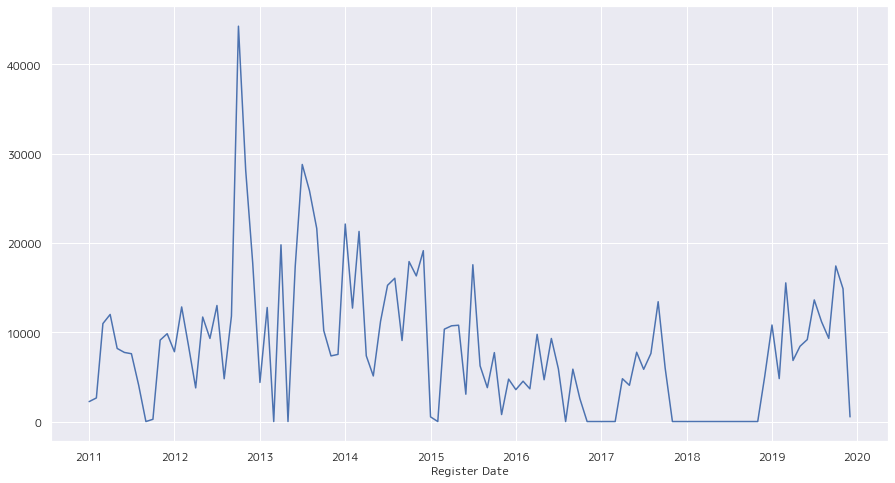

In [44]:
plt.figure(figsize=(15,8))
values = em_series.values
# plot dataset
sns.lineplot(data=em_series.resample('MS').sum())

In [45]:
em_series_month.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01',
               '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-04-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
      

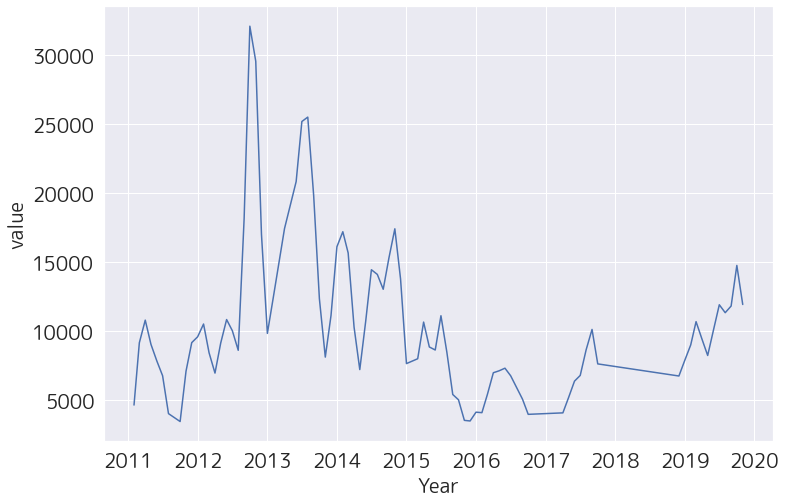

In [46]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [47]:
def series_to_supervised(data, n_in=4, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [48]:
names = ["Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest","LGBM","XGBoost"]
models = [
    GradientBoostingRegressor(),
    DecisionTreeRegressor(max_depth=5),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    LGBMRegressor(),
    XGBRegressor()]

In [49]:
# values = pd.DataFrame(em_series.values)
# dataframe = pd.concat([values.shift(1), values], axis=1)
# dataframe.columns = ['t-1', 't']
# dataframe.dropna(inplace= True)
# target = dataframe.iloc[:,1]
# data = dataframe.iloc[:,:-1]
dataset = series_to_supervised(np.expand_dims(em_series_sample.values,axis=1), n_in=1)
data  = dataset[:,:-1]
target = dataset[:,-1]

In [50]:
# split into train and test sets
size = int(len(em_series_sample) * 0.7)
train_X, test_X = data[0:size], data[size:len(em_series_sample)]
train_y, test_y = target[0:size], target[size:len(em_series_sample)]
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# model = XGBRegressor()
# model = LGBMRegressor()
model.fit(train_X, train_y)
yhat = model.predict(test_X)
rmse = mean_squared_error(test_y, yhat,squared=False)
mape = mean_absolute_percentage_error(test_y, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 2155.314
Test MAPE: 1.739


In [51]:
rmse = []
mape = []
r_squared = []
for  model in models:
    model.fit(train_X, train_y)
    y_pred  = model.predict(test_X)
#     print(y_pred)
    rmse_score = mean_squared_error(test_y, y_pred,squared=False)
    mape_score = np.mean(np.abs((test_y - y_pred)/test_y)*100)
    r_squared_score  = model.score(test_X,test_y)
    r_squared.append(r_squared_score)
    rmse.append(rmse_score)
    mape.append(mape_score)

In [52]:
df_score = pd.DataFrame()
df_score['MODELS'] = names
df_score['R_SQUARED'] = r_squared
df_score['RMSE'] = rmse
df_score['MAPE'] = mape
df_score['RMSE'] = round(df_score['RMSE'],3)
df_score['MAPE'] = round(df_score['MAPE'],3)
df_score['R_SQUARED'] = round(df_score['R_SQUARED'],3)

df_score

,MODELS,R_SQUARED,RMSE,MAPE
0,Gradient_Boosting,-0.051,1765.080,147.449
1,Decision_Tree,0.015,1708.733,149.509
2,Extra_Trees,-0.311,1971.324,164.466
3,Random_Forest,-0.203,1888.849,157.380
4,LGBM,-0.024,1742.748,150.381
5,XGBoost,-0.432,2060.125,167.334


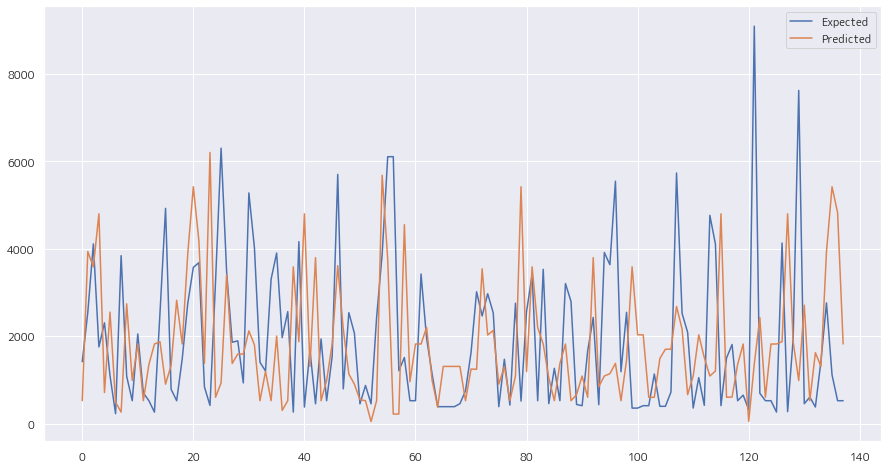

In [53]:
plt.figure(figsize=(15,8))
plt.plot(test_y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

predicted=7.839284, expected=8.131616
predicted=7.952912, expected=6.796824
predicted=7.842370, expected=6.889082
predicted=7.720239, expected=5.827474
predicted=7.323618, expected=7.615397
predicted=7.168293, expected=7.572956
predicted=7.038269, expected=7.843621
predicted=7.098860, expected=7.741968
predicted=7.266747, expected=8.957205
predicted=7.701895, expected=8.475848
predicted=8.076242, expected=7.978369
predicted=8.158085, expected=8.498520
predicted=8.279894, expected=8.211993
predicted=8.352073, expected=8.083329
predicted=8.323725, expected=6.834980
predicted=7.997676, expected=7.659143
predicted=7.851116, expected=6.257041
predicted=7.512491, expected=7.588324
predicted=7.337456, expected=7.446807
predicted=7.243982, expected=8.605255
predicted=7.429178, expected=8.061487
predicted=7.639326, expected=6.257041
predicted=7.493578, expected=7.718685
predicted=7.587558, expected=7.046734
predicted=7.520731, expected=7.758120
predicted=7.478267, expected=8.434650
predicted=7.

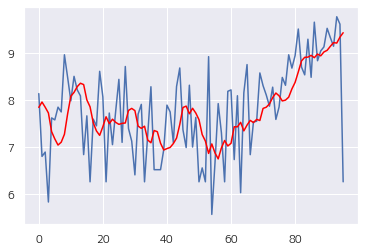

In [54]:
from statsmodels.tsa.arima.model import ARIMA

X = np.log(em_series).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RMSE: 4838.685
MAPE: 1.310


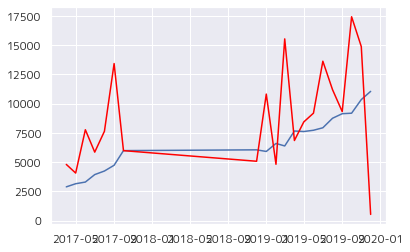

In [55]:
X = em_series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,1))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
#                         FutureWarning)
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
model = ARIMA(em_series, order=(1,1,1))
results = model.fit()
pred = results.predict(start='2017-01', dynamic=False)
y_forecasted = pred
y_truth = em_series['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(y_forecasted)
plt.plot(y_truth, color='red')
plt.show()

<ipython-input-56-ba1bbbfd531d>:6: RuntimeWarning: overflow encountered in exp
  plt.plot(np.exp(test))


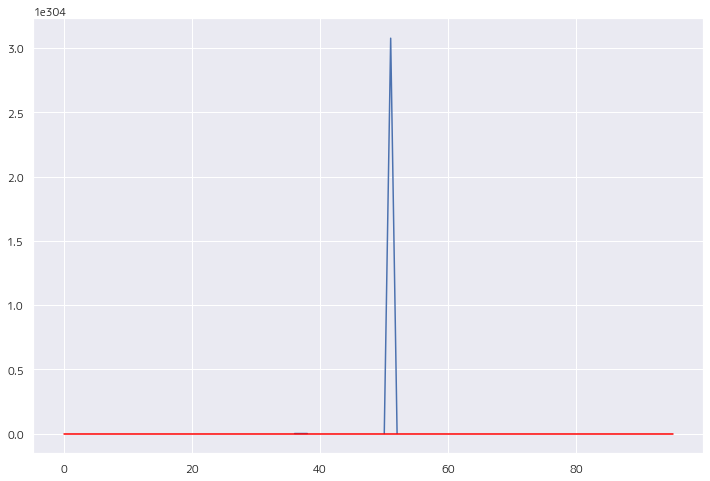

In [56]:
plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.xticks(rotation = 90)
# sns.lineplot(x=list(df_sum_month['month_year'][size:len(X)]),y=np.exp(test),data=np.exp(test))
# plt.legend(loc='upper left', labels=['forecast','test'])
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

In [57]:
X = np.log(em_series_sample).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA')
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
model = ARIMA(em_series_sample, order=(4,1,1))
results = model.fit()
pred = results.predict(start='2017-01-01', dynamic=False)
y_forecasted = pred
y_truth = em_series['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(y_forecasted)
plt.plot(y_truth, color='red')
plt.show()

# plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g.

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

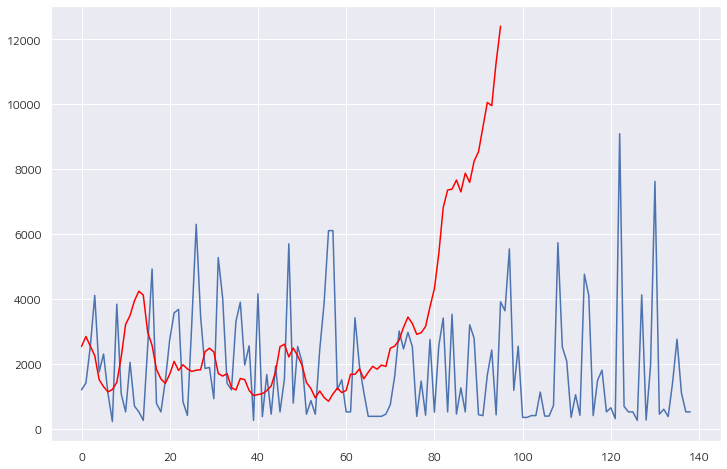

In [58]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

IndexError: arrays used as indices must be of integer (or boolean) type

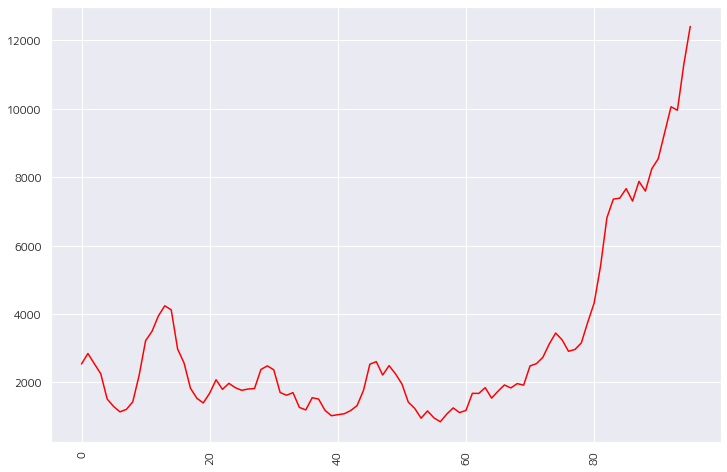

In [59]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
sns.lineplot(x=list(df_sum_day['Register Date'][size:len(X)]),y=np.exp(test),data=np.exp(test))
plt.legend(loc='upper left', labels=['forecast','test'])

In [63]:
X = np.log(em_series_month).values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=5544.012590, expected=9760.000000
predicted=7174.525663, expected=4678.650000
predicted=6561.578294, expected=9301.030000
predicted=7167.966517, expected=5901.960000
predicted=7740.022951, expected=5864.730000
predicted=6852.559964, expected=2559.970000
predicted=6173.844903, expected=4796.716429
predicted=6216.023774, expected=4056.800000
predicted=6139.305535, expected=7759.902857
predicted=6198.537312, expected=5846.890000
predicted=6678.854037, expected=7625.790000
predicted=6788.707554, expected=13418.000000
predicted=8739.369009, expected=5973.345714
predicted=7331.608509, expected=5066.390000
predicted=6879.268382, expected=10808.460000
predicted=8718.809908, expected=4807.590000
predicted=6882.932379, expected=15526.435714
predicted=8055.923804, expected=6839.290000
predicted=8312.426311, expected=8428.140000
predicted=7362.291014, expected=9177.930000
predicted=8763.924154, expected=13618.130000
predicted=8771.273622, expected=11185.350000
predicted=8906.958494, expe

In [64]:
# plt.xticks(rotation = 90)
# plt.plot_date(df_sum_month['month_year'][size:len(X)], np.exp(predictions))
# list_time_test = list(df_sum_month['month_year'][size:len(X)])
# list_time_test

df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
# # list_datetime = list(df_sum_month.reset_index()['month_year'][size:len(X)])
list_datetime
# df_sum_month[df_sum_month['month_year'].map(lambda x: '2017' in x)]

['2016-04-01',
 '2016-05-01',
 '2016-06-01',
 '2016-07-01',
 '2016-09-01',
 '2016-10-01',
 '2017-04-01',
 '2017-05-01',
 '2017-06-01',
 '2017-07-01',
 '2017-08-01',
 '2017-09-01',
 '2017-10-01',
 '2018-12-01',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-01',
 '2019-05-01',
 '2019-06-01',
 '2019-07-01',
 '2019-08-01',
 '2019-09-01',
 '2019-10-01',
 '2019-11-01',
 '2019-12-01']

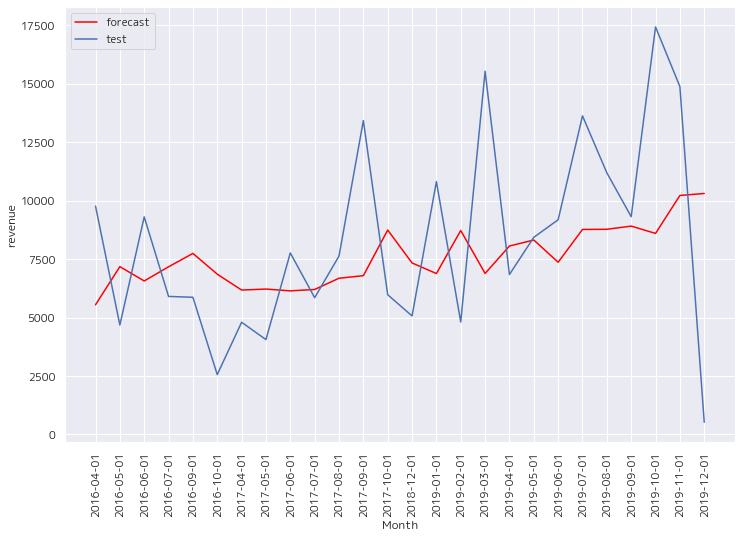

In [65]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

# plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.plot(em_series_month)
# plt.xticks(rotation = 90)
# plt.ylabel('revenue')
# # sns.lineplot(x=list(df_sum_year['year']),y='total_price_1g',data=df_sum_year)
# plt.legend(loc='best', labels=['forecast','test'])

In [66]:
X = em_series_month.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(test, predictions,squared=False)
mape =mean_absolute_percentage_error(test, predictions)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=5074.995805, expected=9760.000000
predicted=6585.288422, expected=4678.650000
predicted=4718.346736, expected=9301.030000
predicted=5740.387988, expected=5901.960000
predicted=5989.996215, expected=5864.730000
predicted=4819.060029, expected=2559.970000
predicted=5264.683818, expected=4796.716429
predicted=5471.355144, expected=4056.800000
predicted=5989.666313, expected=7759.902857
predicted=6483.724004, expected=5846.890000
predicted=5913.416027, expected=7625.790000
predicted=5535.184695, expected=13418.000000
predicted=8912.515194, expected=5973.345714
predicted=5460.853062, expected=5066.390000
predicted=5098.127218, expected=10808.460000
predicted=9272.663400, expected=4807.590000
predicted=6407.216245, expected=15526.435714
predicted=10660.693497, expected=6839.290000
predicted=8443.592595, expected=8428.140000
predicted=6644.860663, expected=9177.930000
predicted=9552.870010, expected=13618.130000
predicted=10216.433729, expected=11185.350000
predicted=10476.975178, e

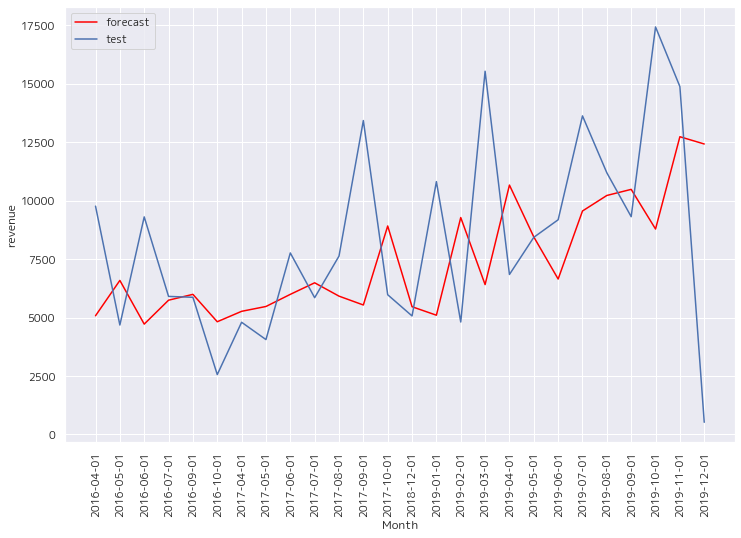

In [67]:
plt.figure(figsize=(12,8))
plt.plot(predictions, color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])


RMSE: 64766.353
MAPE: 1.384


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


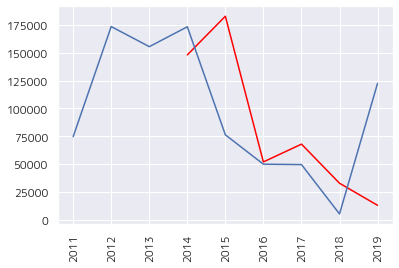

In [68]:
# X = np.log(em_series_year).values
X = em_series_year.values
# size = int(len(X) * 0.5)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
model = ARIMA(em_series_year, order=(1,1,1))
results = model.fit()
pred = results.predict(start='2014-01-01', dynamic=False)
y_forecasted = pred
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.xticks(rotation = 90)
plt.plot(y_forecasted,color='red')
plt.plot(em_series_year)
plt.show()
# predictions = list()|
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(1,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

In [57]:
# df_sum_year.reset_index(inplace=True)
# df_sum_year['year'] = df_sum_year['year'].astype(str)
list_datetime = list(df_sum_year['year'][size:len(X)])
# # list_datetime = list(df_sum_month.reset_index()['month_year'][size:len(X)])
# list_datetime
list(df_sum_year['year'][6:])

[Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00')]

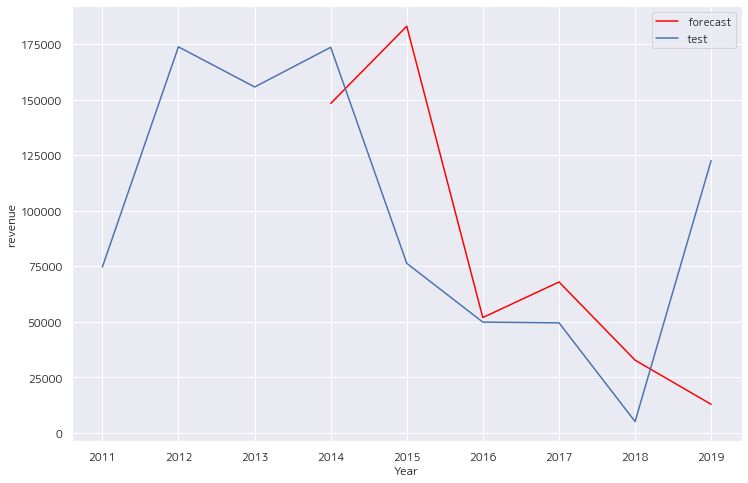

In [69]:
plt.figure(figsize=(12,8))
plt.plot(y_forecasted, color='red')
plt.plot(em_series_year)
# plt.xticks(rotation = 90)
plt.xlabel('Year')
plt.ylabel('revenue')
# sns.lineplot(x=list(df_sum_year['year']),y='total_price_1g',data=df_sum_year)
plt.legend(loc='best', labels=['forecast','test'])

In [66]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [67]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1982.7833235803098
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1698.1831203577574
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1665.986991926892
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1385.7193425808086
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1683.8362904663777
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1643.5251817513379
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1403.1813048499891
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1383.2737938190285
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1924.9525860926606


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1656.2675250117913
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1641.4449800331279
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1360.3671544757278
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1694.124083396273
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1643.5155538824215
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1404.458125179162


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1360.3790268631285
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1863.2215027463812
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1607.1477070476728
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1670.8674518896369
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1371.4771271001146
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1627.5256632942283
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1608.9748548474417
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1404.7821227605486
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1367.6246103650928


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1812.6070892418961
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1560.9806732046275
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1624.56146562556
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1326.2488693682646
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1602.9357790973677
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1562.9136745773305


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1384.0230967822622
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1327.3170435283566
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1879.3469720880887
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1625.4454605157873
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1660.9167899738138
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1377.3785531912022


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1625.6731752330238
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1627.9078963205563
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1381.5190327274374
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1378.544786689905
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1835.240487578445


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1584.309362743688
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1640.3771211023266
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1347.5592188439505


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1604.699870182405
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1586.6125822292106
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1381.5421955526642


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1348.829217652679
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1848.4009263550306
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1597.5849969069266
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1655.6647488812678
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1357.2435756983377
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1597.7917939583283
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1598.0573255395116
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1373.7887805646953


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1359.18935894085
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1813.447408586416
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1560.8467468864558
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1620.6831545092186
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1328.0999538270519


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1582.7757472498677
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1561.4754873972415
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1364.1875242888589


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1329.1348779260666


In [100]:
mod =SARIMAX(em_series_month,
                                order=(5, 0, 1),
                                seasonal_order=(5, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2374      7.816     -0.030      0.976     -15.556      15.081
ar.L2         -1.1791     15.197     -0.078      0.938     -30.965      28.607
ar.L3         -0.1817      9.879     -0.018      0.985     -19.543      19.180
ar.L4         -0.2402     14.505     -0.017      0.987     -28.669      28.188
ar.L5         -0.0471      7.252     -0.006      0.995     -14.260      14.166
ma.L1         -0.8380      6.489     -0.129      0.897     -13.556      11.880
ar.S.L12       0.4284      4.068      0.105      0.916      -7.544       8.401
ar.S.L24      -0.2197      1.179     -0.186      0.852      -2.530       2.091
ar.S.L36       0.0745      1.326      0.056      0.955      -2.525       2.674
ar.S.L48       0.2588      1.591      0.163      0.871      -2.860       3.378
ar.S.L60       0.2436      1.078      0.226      0.8

D:\Software\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [101]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x576 with 0 Axes>

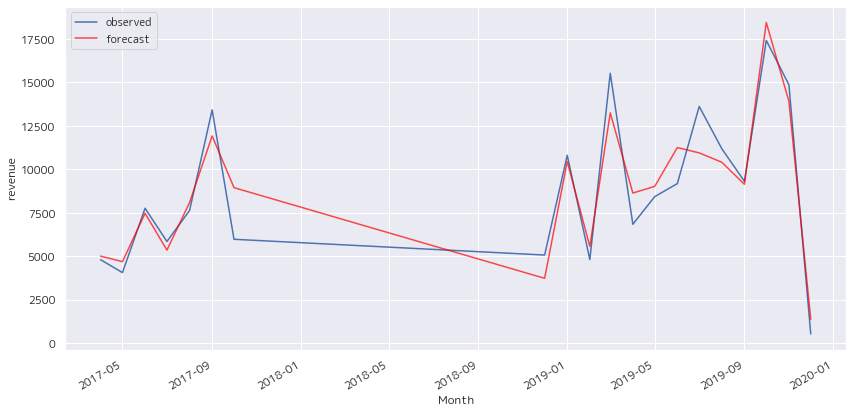

In [102]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [103]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 1379.998
MAPE: 0.209


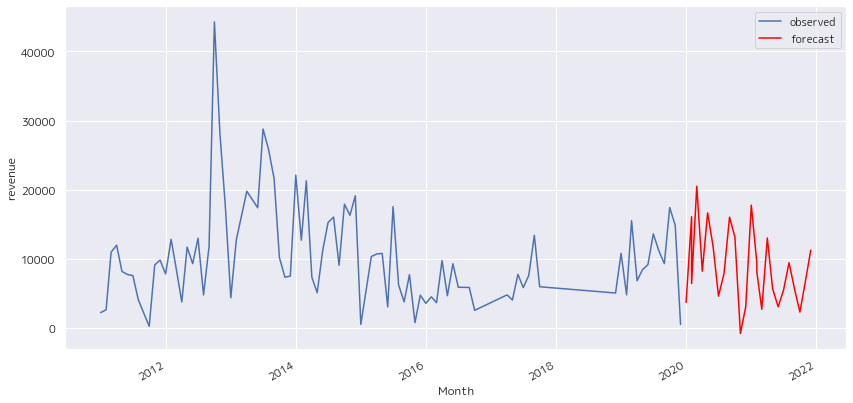

In [104]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [105]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,3692.049825
2020-02-01,16095.764826
2020-03-01,20501.965757
2020-02-01,6438.933571
2020-04-01,8223.226234
2020-05-01,16661.072269
2020-06-01,11728.610177
2020-07-01,4613.748249
2020-08-01,7896.941336
2020-09-01,16031.845940


In [126]:
mod =SARIMAX(em_series_year,
                                order=(0, 0, 1),
                                seasonal_order=(0, 0, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

# mod =SARIMAX(em_series_year,
#                                 order=(1, 0, 0),
#                                 seasonal_order=(0, 0, 1, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)

# results = mod.fit()

# print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1027      2.827     -0.036      0.971      -5.644       5.439
ma.S.L2        0.6574      0.383      1.718      0.086      -0.092       1.407
sigma2      5.477e+09   4.16e-10   1.32e+19      0.000    5.48e+09    5.48e+09


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


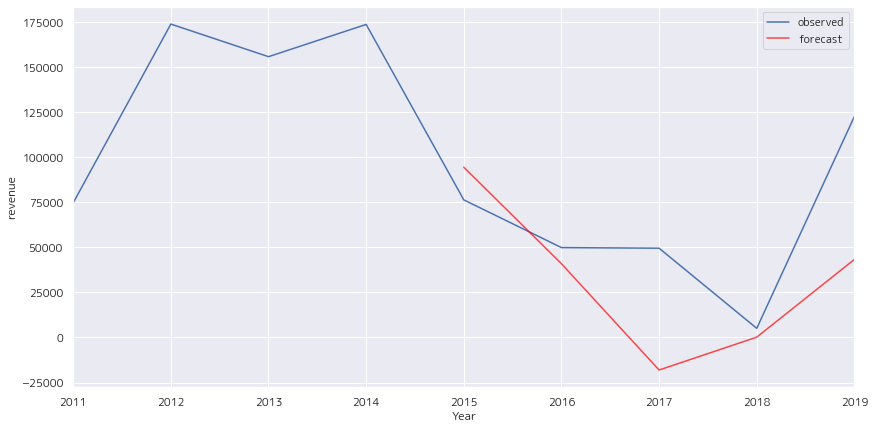

In [127]:
pred = results.get_prediction(start='2015-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2011-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 7),color='red')

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [128]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2015-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
# mape = mean_absolute_percentage_error(y_forecasted,y_truth)

print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 47472.950
MAPE: 0.679


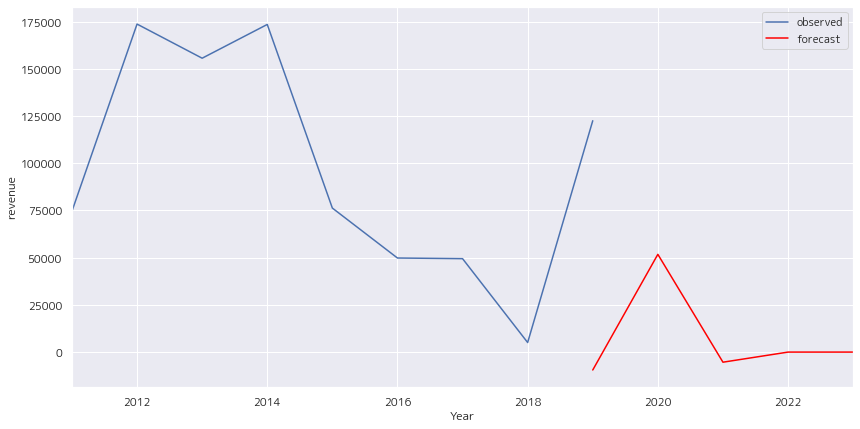

In [129]:
index = pd.to_datetime(['2019','2020','2021','2022','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [130]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,-9489.139238
2020-01-01,51764.414535
2021-01-01,-5351.719268
2022-01-01,0.000000
2023-01-01,0.000000


In [131]:
df_1nz  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'NA20' in x)]
df_1nz

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
39167,4644,2011-04-19,8407343009,"ЗАП.ЧАСТИ ДЛЯ А/М, Б/У ДВИГАТЕЛЯ С АКП ЯПОНСКО...","TOYOTA,NISSAN","TOYOTA,NISSAN",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","JAPROS CO., LTD",...,CFR,350.0,350.0,175.00,[NA20],NISSAN,2011-04,2011,1,1
39171,4831,2011-04-08,8407343009,"ДВИГАТЕЛЬ А/М Б/У В СБОРЕ С КПП, БЕНЗИНОВЫЙ,С ...",NISSAN,NISSAN,ВЛАДИВОСТОК,"JP, JPN, Japan","VG, VGB, British Virgin Islands","ДЖИ ПИ ТРАЙДИНГ КО., ЛТД",...,CFR,500.0,500.0,645.00,[NA20],NISSAN,2011-04,2011,1,1
39185,11535,2011-07-11,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"NISSAN MOTOR CO.,LTD,TOYOTA MOTOR CORPORATION,...","NISSAN,TOYOTA,MITSUBISHI,SUZUKI,SUBARU,HONDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","A.R.TRADING CO.,LTD 2734 NUMAZAWA OOAZA HIOGAS...",...,CFR,6890.0,6890.0,6891.90,[NA20],NISSAN,2011-07,2011,1,1
39189,12410,2011-08-10,8407343009,ДВИГАТЕЛИ ДИЗЕЛЬНЫЕ В СБОРЕ С КОРОБКОЙ ПЕРЕДАЧ...,NISSAN,NISSAN,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","MIKHAIL COMPANY CO., LTD",...,CFR,250.0,250.0,250.00,[NA20],NISSAN,2011-08,2011,1,1
39193,12684,2011-08-25,8407343009,"ДВИГАТЕЛЬ КАРБЮРАТОР БЫВ.УП.ДЛЯ Л/А,ОБЪЕМ 1300...",TOYOTA MOTOR CORP. MMC MOTORS NISSAN MOTOR CO....,":TOYOTA,NISSAN,MMC,SUBARU,HONDA,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",HYUNDAI MERCHANT MARINE CO.O/B OF R.M.TRADING ...,...,CFR,3320.0,3320.0,3050.00,[NA20],NISSAN,2011-08,2011,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40054,247321,2019-10-01,8407343009,"ДВИГАТЕЛИ ВНУТРЕН. СГОРАНИЯ С ИСКР. ЗАЖИГ, БЕН...",NISSAN,NISSAN,ВЛАДИВОСТОК,"JP, JPN, Japan",JAPAN,BSI LLC,...,CFR,1719.0,1719.0,2595.69,[NA20],NISSAN,2019-10,2019,1,1
40055,247353,2019-10-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",NISSAN,NISSAN,ВЛАДИВОСТОК,"JP, JPN, Japan",JAPAN,ROOTS CO. LTD,...,CFR,330.0,330.0,496.98,[NA20],NISSAN,2019-10,2019,1,1
40056,247697,2019-10-01,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ БЫВ.В УПОТР, ДЛЯ Л/А,ОБЪЕ...",NISSAN MOTOR CO.LTD,:NISSAN РЕГИСТРАЦИОННЫЙ ПО ТРОИС № 02277/01855-01,ВОСТОЧНЫЙ,"JP, JPN, Japan",JAPAN,NKR CO.LTD,...,CFR,2148.0,2148.0,3375.00,[NA20],NISSAN,2019-10,2019,1,1
40071,248597,2019-10-01,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ БЫВ.В УПОТР, ДЛЯ Л/А,ОБЪЕ...",NISSAN MOTOR CO.LTD,:NISSAN РЕГИСТРАЦИОННЫЙ ПО ТРОИС № 02277/01855-01,ВОСТОЧНЫЙ,"JP, JPN, Japan",JAPAN,NKR CO.LTD,...,CFR,2250.0,2250.0,3375.00,[NA20],NISSAN,2019-10,2019,1,1


In [132]:
df_1nz['count_em']  = df_1nz['extracted_engine'].map(lambda x: count_length(x,'F23A'))
unit_price_1nz = df_1nz[(df_1nz.Quantity == 1) & (df_1nz.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_1nz['Quantity'] = df_1nz.apply(lambda x : normalize_zero (x,unit_price_1nz), axis=1)
df_1nz['total_price'] = df_1nz.apply(lambda x : check_count_em(x,unit_price_1nz),axis=1)

<ipython-input-132-9eb91f3018c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['count_em']  = df_1nz['extracted_engine'].map(lambda x: count_length(x,'F23A'))
<ipython-input-3-8b73a2289c4c>:16: RuntimeWarning: invalid value encountered in double_scalars
  if row['Cargo Value USD'] % unit_price < 2:
<ipython-input-3-8b73a2289c4c>:19: RuntimeWarning: invalid value encountered in double_scalars
  return row['Cargo Value USD'] // unit_price
<ipython-input-132-9eb91f3018c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [133]:
df_1g  = df_copy[df_copy["extracted_engine"].apply(lambda x : '4G64' in x)]
df_1g

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
24135,1239,2011-02-01,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"MITSUBISHI,TOYOTA,MAZDA,HONDA","MITSUBISHI,TOYOTA,MAZDA,HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan",PIONEER COMPANY LTD.,...,CFR,5730.0,5730.0,3617.32,"[4G93, 4G64]",MITSUBISHI,2011-02,2011,2,2
24143,1681,2011-02-09,8407343009,"ДВИГАТЕЛЬ ВНУТР. СГОРАНИЯ ДЛЯ Л/АВТОМОБИЛЯ, С ...","MITSUBISHI MOTOR CO., MITSUBISHI",MITSUBISHI,П-КАМЧАТСКИЙ,"JP, JPN, Japan","CT, , Taiwan","DRUZHBA CO., LTD.",...,CFR,613.8,613.8,693.00,"[4G64, 4G63]",MITSUBISHI,2011-02,2011,2,2
24160,2691,2011-02-28,8407343009,ДВИГАТЕЛИ БЕНЗ.БЫВ.В УП.В СБОРЕ С НАВЕСНЫМ ОБО...,"TOYOTA MOTOR CORPORATION,HONDA MOTOR CO.,LTD,N...","TOYOTA,HONDA,NISSAN,SUZUKI,MMC",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan","JEEP SIB CO.,LTD",...,CFR,6970.0,6970.0,3400.00,"[4G64, 4G63]",MITSUBISHI,2011-02,2011,2,2
24176,2885,2011-03-14,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"HONDA MOTOR CO.,LTD,MITSUBISHI MOTORS CORPORAT...","HONDA,MITSUBISHI,MAZDA,SUBARU",CFR ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","ROYAL AUTO PARTS CO.,LTD 724-141 OKIHARU BESHI...",...,CFR,9029.4,9029.4,8934.67,"[4G15, 4G64, 4G64, 4G64, 4G63]",MITSUBISHI,2011-03,2011,3,5
24177,2890,2011-03-14,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"HONDA MOTOR CO.,LTD,MITSUBISHI MOTORS CORPORAT...","HONDA,MITSUBISHI,MAZDA,SUBARU",CFR ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",HEIWA SYOUJI KABUSHIKIGAISHA 10-8 MINAMIFUTAJI...,...,CFR,7068.6,7068.6,6962.42,"[4G13, 4G64]",MITSUBISHI,2011-03,2011,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30243,257586,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ БЫВШИЕ В УПОТРЕБЛЕНИИ СТА...,MITSUBISHI MOTOR CO,MITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",KUSAYAMA PARTS CO. LTD,...,CFR,2450.0,2450.0,3765.79,"[4G15, 4G64]",MITSUBISHI,2019-12,2019,2,2
30244,257683,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",IWAMA WORKS CO. LTD,...,CFR,260.0,260.0,393.06,[4G64],MITSUBISHI,2019-12,2019,1,1
30251,257880,2019-12-01,8407343009,"ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М, Б/У, ДВИГАТЕЛИ ВНУТРЕН...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",MARUKO SHOJI CO. LTD.,...,CFR,960.0,960.0,1449.60,"[4G93, 4G64]",MITSUBISHI,2019-12,2019,2,2
30255,257959,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",KAWASHIMA CO.LTD,...,CFR,240.0,240.0,361.99,[4G64],MITSUBISHI,2019-12,2019,1,1


In [123]:
df_1g['count_em']  = df_1g['extracted_engine'].map(lambda x: count_length(x,'D15B'))
unit_price_1g = df_1g[(df_1g.Quantity == 1) & (df_1g.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_1g['Quantity'] = df_1g.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
df_1g['total_price'] = df_1g.apply(lambda x : check_count_em(x,unit_price_1g),axis=1)

<ipython-input-123-bc9c92a6926c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1g['count_em']  = df_1g['extracted_engine'].map(lambda x: count_length(x,'D15B'))
<ipython-input-3-8b73a2289c4c>:16: RuntimeWarning: invalid value encountered in double_scalars
  if row['Cargo Value USD'] % unit_price < 2:
<ipython-input-3-8b73a2289c4c>:19: RuntimeWarning: invalid value encountered in double_scalars
  return row['Cargo Value USD'] // unit_price
<ipython-input-123-bc9c92a6926c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [124]:
df_fp  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'L13A' in x)]
df_fp

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
24127,91,2011-01-21,8407343009,"ЗАП.ЧАСТИ ДЛЯ А/М, Б/У ДВИГАТЕЛЯ С АКП ЯПОНСКО...","TOYOTA,MITSUBISHI,SUBARU","TOYOTA,MITSUBISHI,SUBARU",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","АВТОЛОМ ДЖАПАН КО.,ЛТД",...,CFR,600.0,600.0,480.00,[4G15],MITSUBISHI,2011-01,2011,1,1
24131,974,2011-01-18,8407343009,"ДВИГАТЕЛИ БЕНЗИН.-21ШТ.,БЫВ.В УПОТРЕБЛ.ДЛЯ ЛЕК...","HONDA MOTOR COMPANY,TOYOTA MOTOR CORPORATION,S...","HONDA,TOYOTA,SUBARU,MITSUBISHI,NISSAN,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","YAMADA MOTOR CO.,LTD.16-6,SHIMIZU-KU NISHITAKA...",...,CFR,4594.0,4594.0,6891.00,"[6G74, 4G15]",MITSUBISHI,2011-01,2011,2,2
24144,1698,2011-02-08,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М В СБОРЕ С АКП:...,MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan",WAKE CORPORATION LTD,...,CFR,2079.0,2079.0,752.40,"[4G13, 4G15, 6A13, 6A13]",MITSUBISHI,2011-02,2011,3,4
24155,2636,2011-02-24,8407343009,"ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ОБЪЁМОМ БОЛЕЕ 1000СМ3, ...","HONDA, TOYOTA, MITSUBISHI, NISSAN",HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan","FESCO LINES VLADIVOSTOK,LLC, 34POSYETSKAYA STR...",...,CFR,2280.0,2280.0,1080.00,[4G15],MITSUBISHI,2011-02,2011,1,1
24161,2695,2011-02-28,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"MITSUBISHI MOTORS CORPORATION, MITSUBISHI",MITSUBISHI,CFR ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan","ROYAL AUTO PARTS CO.,LTD 724-141 OKIHARU BESHI...",...,unknown,7480.0,7480.0,7534.52,"[4G15, 4G15, 4G15, 4G15, 4G15]",MITSUBISHI,2011-02,2011,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30259,258189,2019-12-01,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,FUJI HEAVY INDUSTRIES CO.LTDMITSUBISHI MOTORS ...,SUBARUMITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",WEST-JAPAN AUTO RECYCLE CO.LTD (WARC),...,CFR,1229.0,1229.0,1866.49,"[6G74, 4G15, 4B11]",MITSUBISHI,2019-12,2019,3,3
30264,258373,2019-12-01,8407343009,"ДВИГАТЕЛЬ АВТОМОБИЛЬНЫЙ БЫВШИЙ В УПОТРЕБЛЕНИИ,...",MITSUBISHI MOTORS CORPORATION,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","HK, HKG, Hong Kong",TRUTH LOGISTICS CORPORATION,...,CFR,570.0,570.0,855.06,"[4G15, 4A91, 4A91]",MITSUBISHI,2019-12,2019,2,3
30266,258418,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,CFR,210.0,210.0,316.36,[4G15],MITSUBISHI,2019-12,2019,1,1
30267,258419,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,CFR,210.0,210.0,316.36,[4G15],MITSUBISHI,2019-12,2019,1,1


In [125]:
df_fp['count_em']  = df_fp['extracted_engine'].map(lambda x: count_length(x,'L13A'))
unit_price_1g = df_fp[(df_fp.Quantity == 1) & (df_fp.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_fp['Quantity'] = df_fp.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
df_fp['total_price'] = df_fp.apply(lambda x : check_count_em(x,unit_price_1g),axis=1)

<ipython-input-125-b245907ec55e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fp['count_em']  = df_fp['extracted_engine'].map(lambda x: count_length(x,'L13A'))
<ipython-input-3-8b73a2289c4c>:16: RuntimeWarning: invalid value encountered in double_scalars
  if row['Cargo Value USD'] % unit_price < 2:
<ipython-input-3-8b73a2289c4c>:19: RuntimeWarning: invalid value encountered in double_scalars
  return row['Cargo Value USD'] // unit_price
<ipython-input-125-b245907ec55e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [137]:
df_3s['name_em'] = 'RB20'
df_1nz['name_em'] = 'NA20'
# df_1g['name_em'] = 'D15B'
# df_fp['name_em'] = 'L13A'

<ipython-input-137-7c39e6be662a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['name_em'] = 'RB20'
<ipython-input-137-7c39e6be662a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['name_em'] = 'NA20'


In [138]:
df_best_engine  = pd.concat([df_3s,df_1nz],axis=0)

In [139]:
df_group_year = df_best_engine.groupby(['year','name_em'])['total_price'].sum().reset_index()
df_group_year

,year,name_em,total_price
0,2011,NA20,11266.900000
1,2011,RB20,74622.080714
2,2012,NA20,8044.990000
3,2012,RB20,173709.059286
4,2013,NA20,39519.540000
5,2013,RB20,155635.825000
6,2014,NA20,41343.340000
7,2014,RB20,173505.875714
8,2015,NA20,26820.450000
9,2015,RB20,76271.350000


Text(0.5, 0, 'Year')

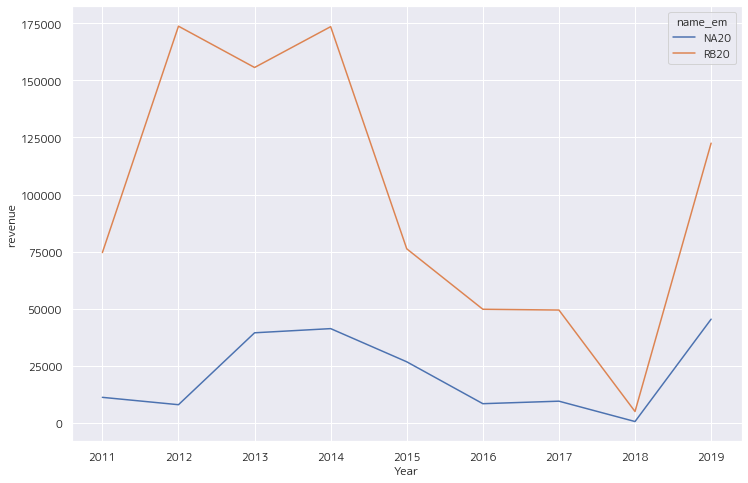

In [140]:
plt.figure(figsize=(12,8))
sns.lineplot(x='year',y='total_price',hue='name_em',data=df_group_year)
plt.ylabel('revenue')
plt.xlabel('Year')

In [141]:
df_group_month = df_best_engine.groupby(['month_year','name_em'])['total_price'].sum().reset_index()
df_group_month

,month_year,name_em,total_price
0,2011-01,RB20,2230.000000
1,2011-02,RB20,2640.000000
2,2011-03,RB20,10968.720000
3,2011-04,NA20,820.000000
4,2011-04,RB20,11990.726429
...,...,...,...
139,2019-10,NA20,14211.450000
140,2019-10,RB20,17420.062143
141,2019-11,RB20,14870.902857
142,2019-12,NA20,705.040000


Text(0.5, 0, 'Month')

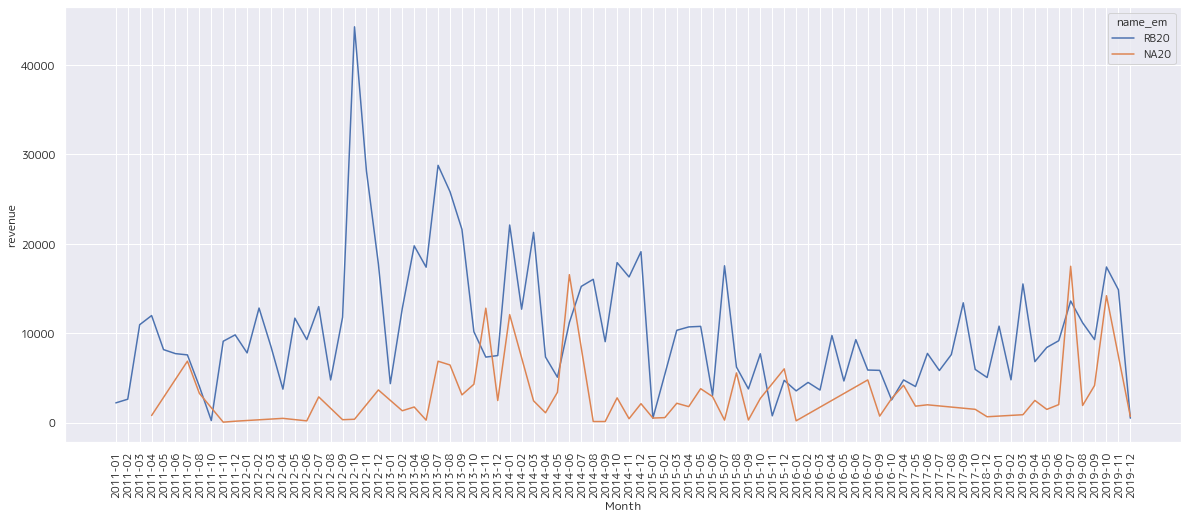

In [142]:
plt.figure(figsize=(20,8))
sns.lineplot(x='month_year',y='total_price',hue='name_em',data=df_group_month)
plt.xticks(rotation = 90)
plt.ylabel('revenue')
plt.xlabel('Month')

Text(0.5, 0, 'Month')

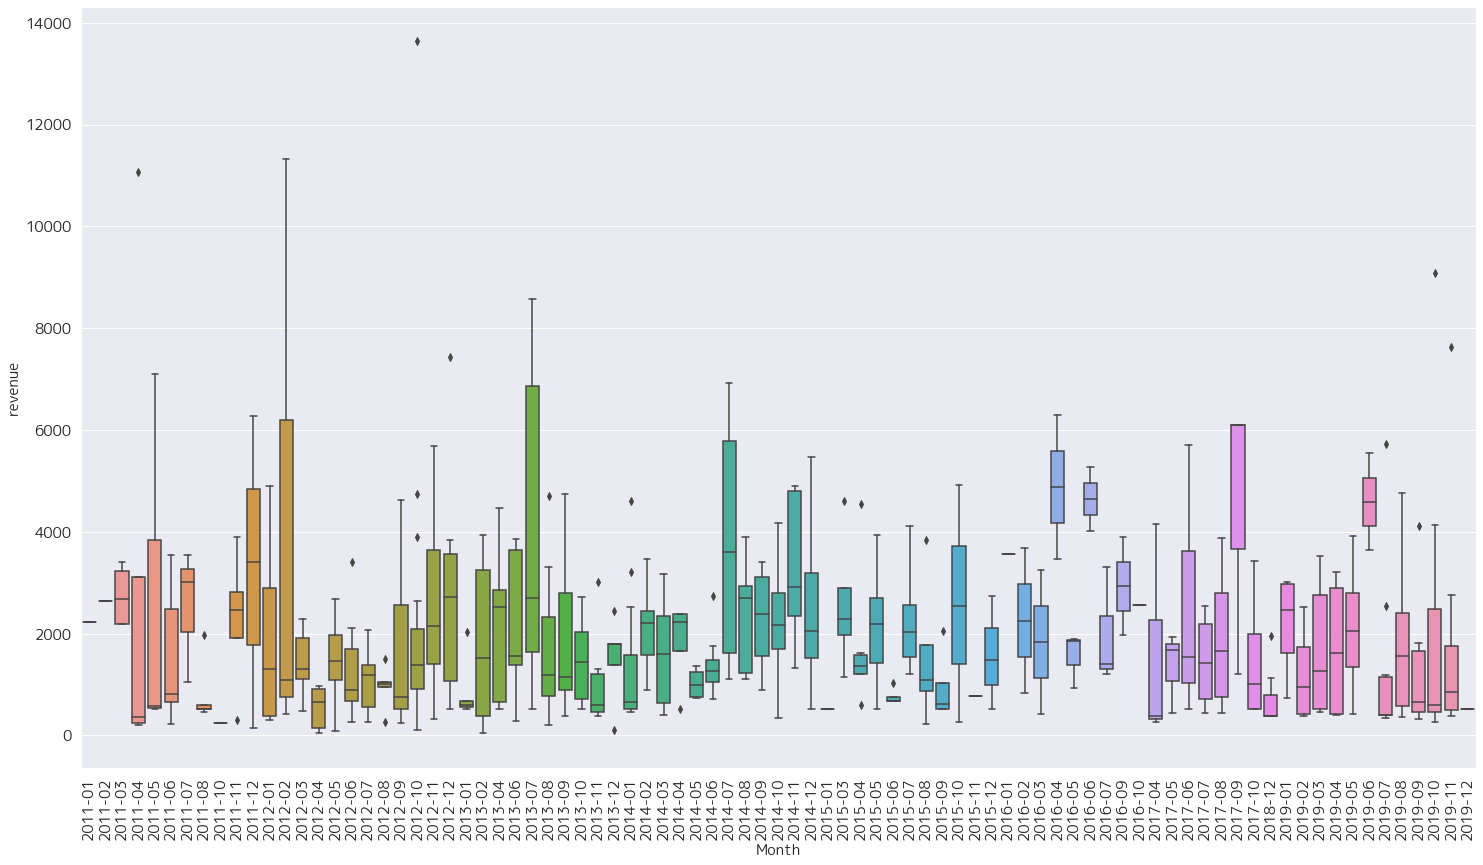

In [143]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_3s)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

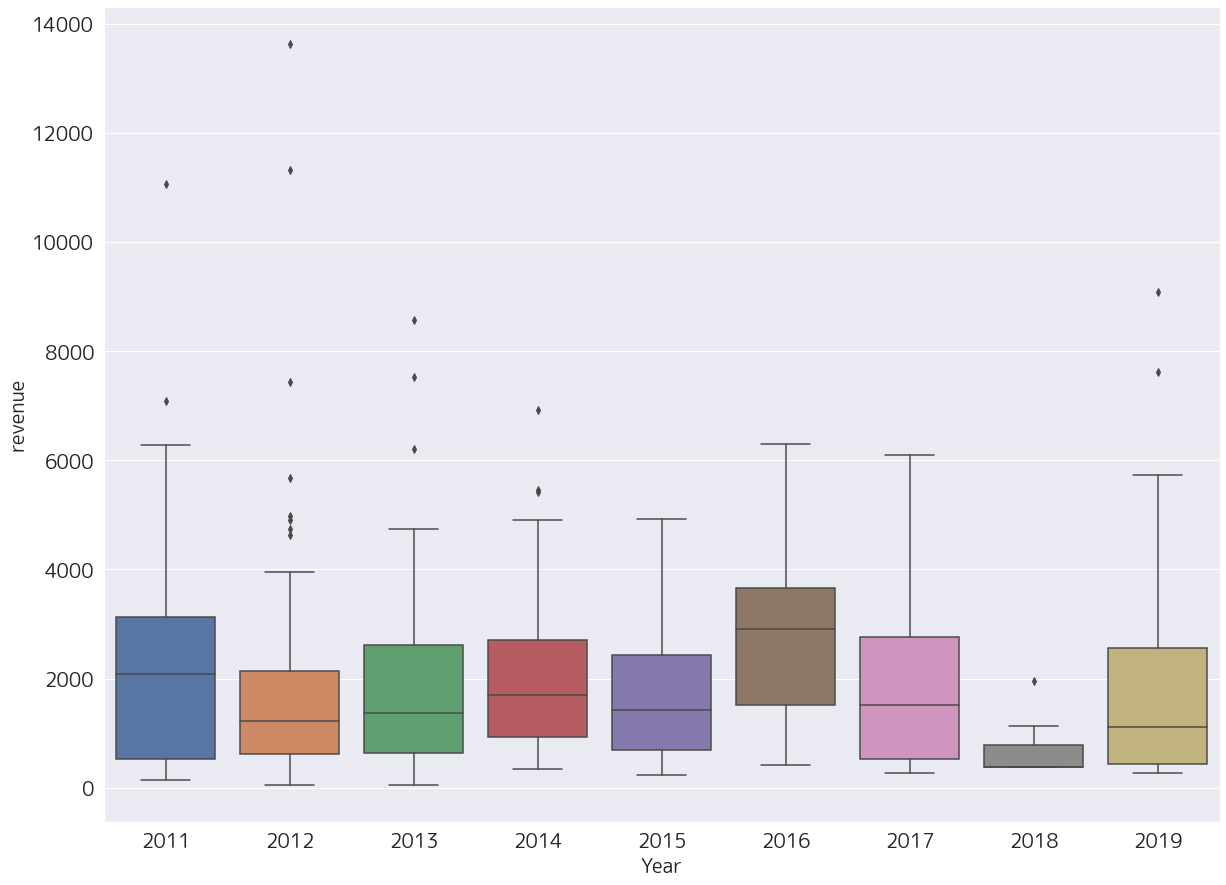

In [144]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_3s)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)

# Engine Model NA20

In [145]:
df_sum_day = df_1nz.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_1nz.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_1nz.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_1nz.total_price.values,index=df_1nz['Register Date'])

Text(0.5, 0, 'Month')

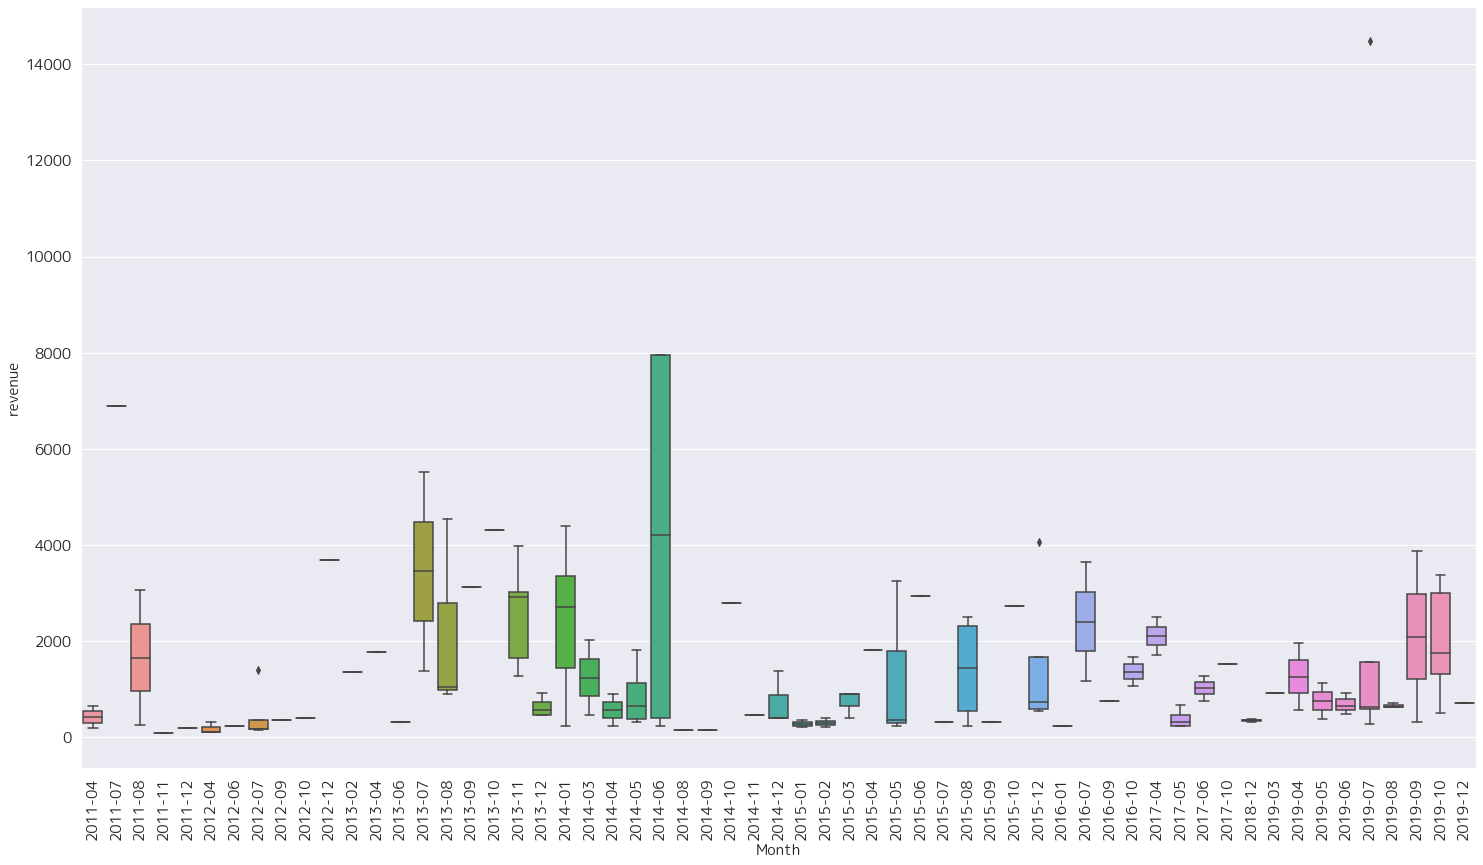

In [146]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_1nz)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

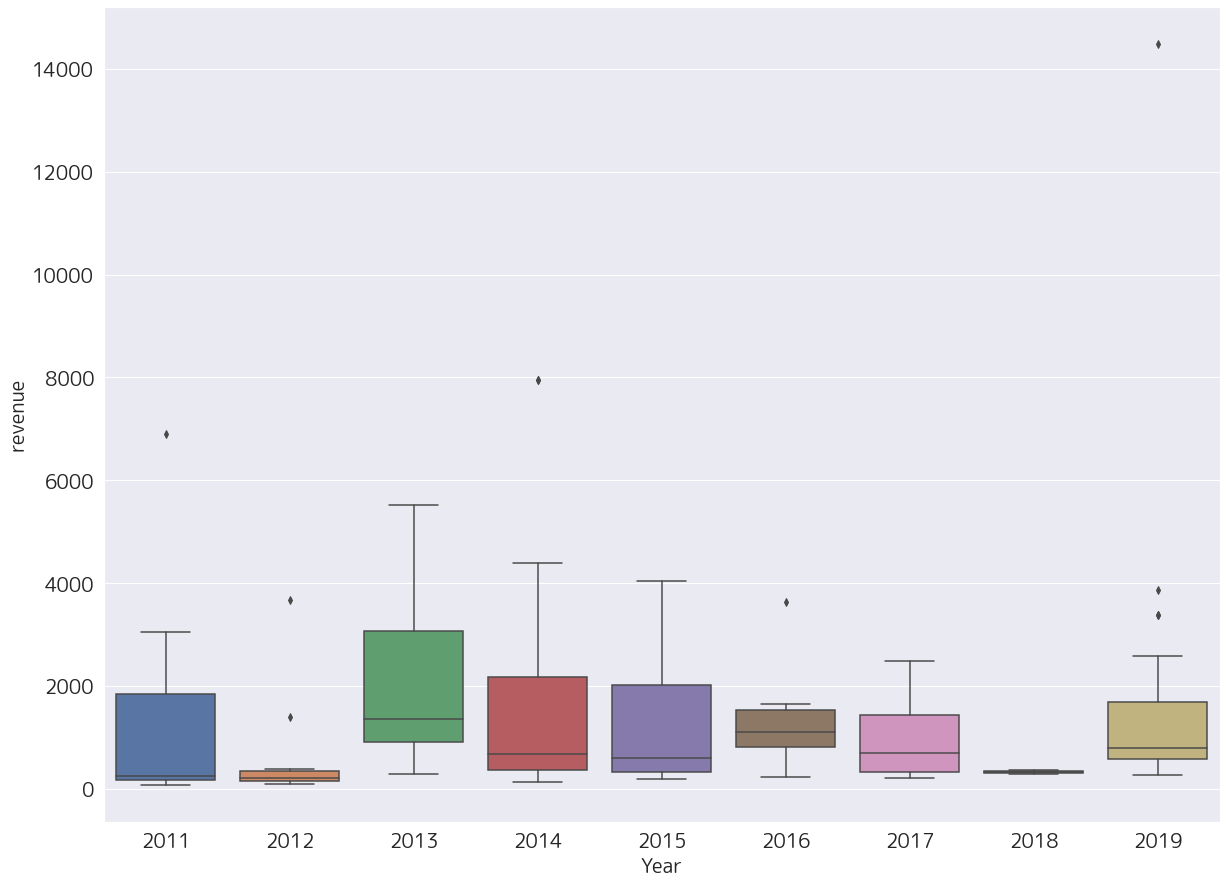

In [147]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_1nz)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)

In [148]:
X = np.log(em_series_month).values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=826.559630, expected=227.000000
predicted=1994.239395, expected=4798.000000
predicted=1671.154030, expected=750.000000
predicted=996.806029, expected=2715.110000
predicted=3481.015654, expected=4197.000000
predicted=708.039878, expected=1864.800000
predicted=3287.073556, expected=2015.000000
predicted=1870.082679, expected=1510.000000
predicted=2294.339773, expected=679.500000
predicted=2065.556562, expected=906.000000
predicted=1329.257909, expected=2502.900000
predicted=1307.267505, expected=1502.080000
predicted=1242.598684, expected=2037.520000
predicted=1390.907123, expected=17501.920000
predicted=2200.913166, expected=1938.880000
predicted=2005.740053, expected=4171.000000
predicted=4617.312866, expected=14211.450000
predicted=3529.519433, expected=705.040000
RMSE: 4630.615
MAPE: 0.980


D:\Software\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


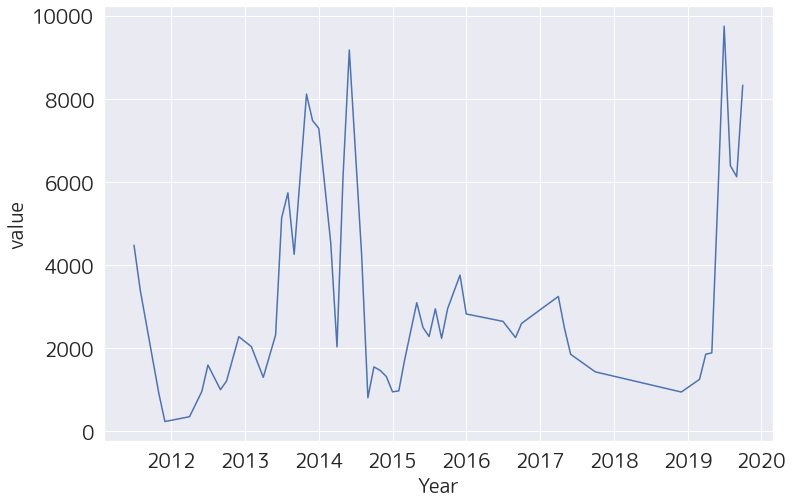

In [149]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

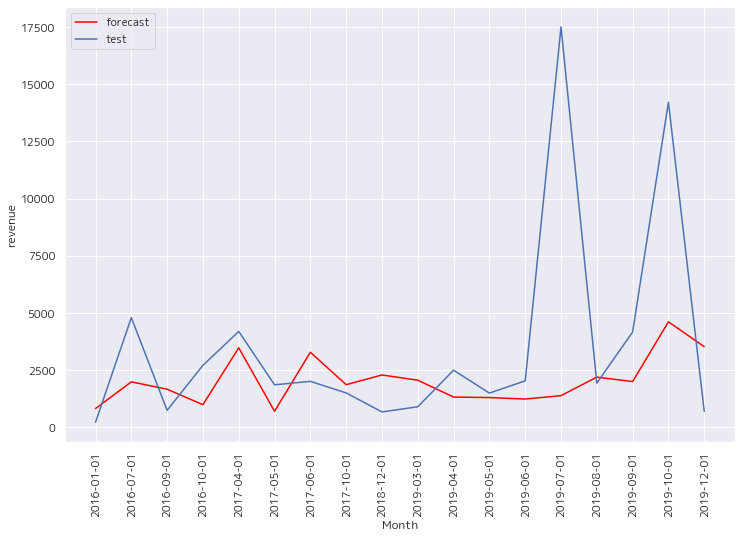

In [150]:
df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])


In [151]:
X = np.log(em_series_year).values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=15164.902011, expected=9586.800000
predicted=13533.394416, expected=679.500000
predicted=2474.327836, expected=45476.790000
RMSE: 26112.255
MAPE: 6.815


In [152]:
import math
min_aic = math.inf
list_param = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_year,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic  = results.aic
                list_param.clear()
                list_param.append(param)
                list_param.append(param_seasonal)
print(min_aic,list_param)

NameError: name 'pdq' is not defined

In [189]:
mod =SARIMAX(em_series_month,
                                order=(5, 0, 0),
                                seasonal_order=(5, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0194         -0        inf      0.000      -0.019      -0.019
ar.L2          0.1826         -0       -inf      0.000       0.183       0.183
ar.L3          0.4834         -0       -inf      0.000       0.483       0.483
ar.L4          0.1803         -0       -inf      0.000       0.180       0.180
ar.L5          0.0731         -0       -inf      0.000       0.073       0.073
ar.S.L12            0         -0        nan        nan           0           0
ar.S.L24            0         -0        nan        nan           0           0
ar.S.L36            0         -0        nan        nan           0           0
ar.S.L48            0         -0        nan        nan           0           0
ar.S.L60            0         -0        nan        nan           0           0
sigma2      1.561e+07         -0       -inf      0.0

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\Software\Anaconda\lib\site-packages\statsmodels\tools\eval_measures.py:406: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf 

In [190]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x576 with 0 Axes>

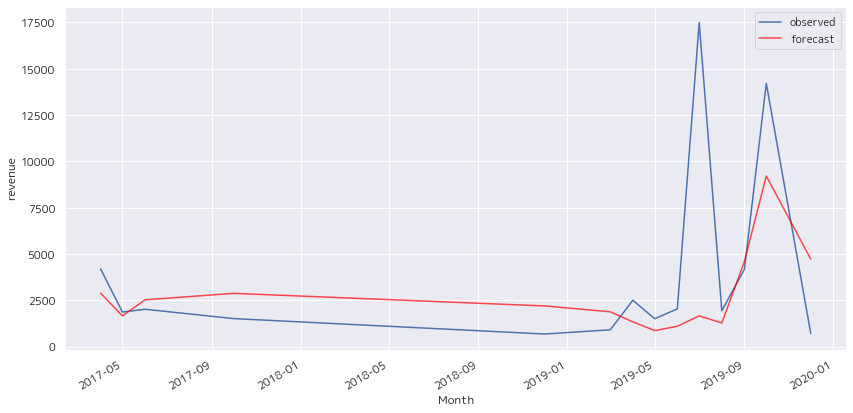

In [191]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [192]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 4649.399
MAPE: 0.975


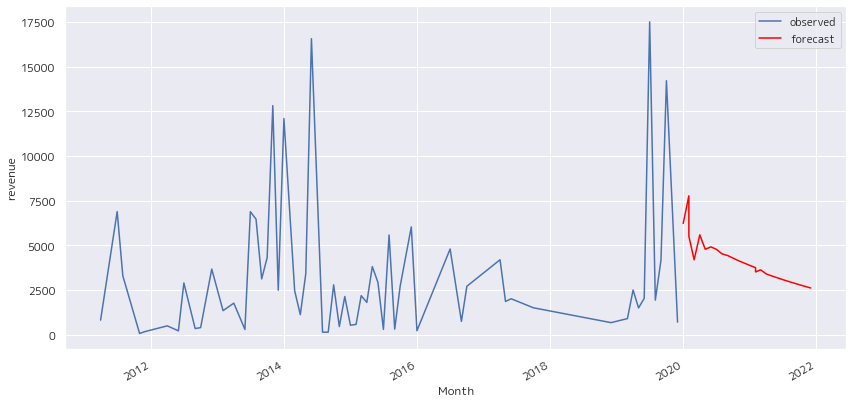

In [193]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [194]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,6226.559166
2020-02-01,7771.329693
2020-03-01,4194.175432
2020-02-01,5513.616882
2020-04-01,5589.481743
2020-05-01,4782.090460
2020-06-01,4917.391744
2020-07-01,4780.335757
2020-08-01,4527.591146
2020-09-01,4432.846752


In [294]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [295]:
import math
min_aic = math.inf
list_param = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_year,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic  = results.aic
                list_param.clear()
                list_param.append(param)
                list_param.append(param_seasonal)
print(min_aic,list_param)

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations 

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

2.0 [(0, 0, 0), (0, 1, 0, 12)]


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

In [305]:
mod =SARIMAX(em_series_year,
                                order=(1, 0, 0),
                                seasonal_order=(0, 1, 0, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3867      0.495      0.781      0.435      -0.584       1.357
sigma2      5.785e+08   1.32e-10   4.39e+18      0.000    5.79e+08    5.79e+08


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


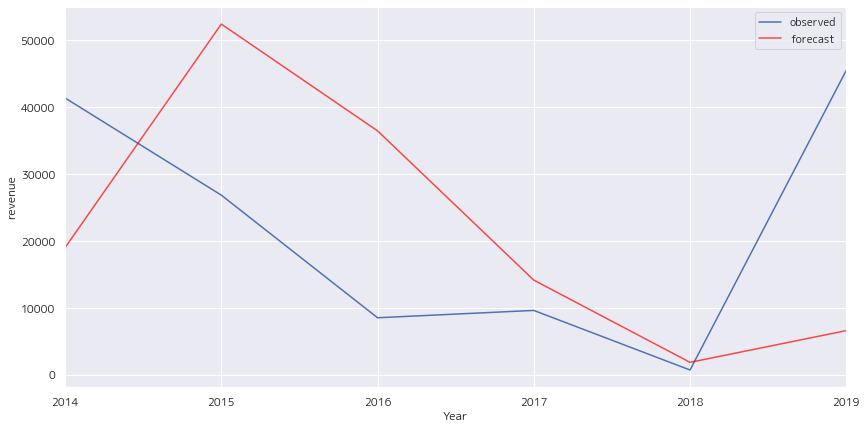

In [306]:
pred = results.get_prediction(start='2014-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2014-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [307]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 24053.032
MAPE: 1.300


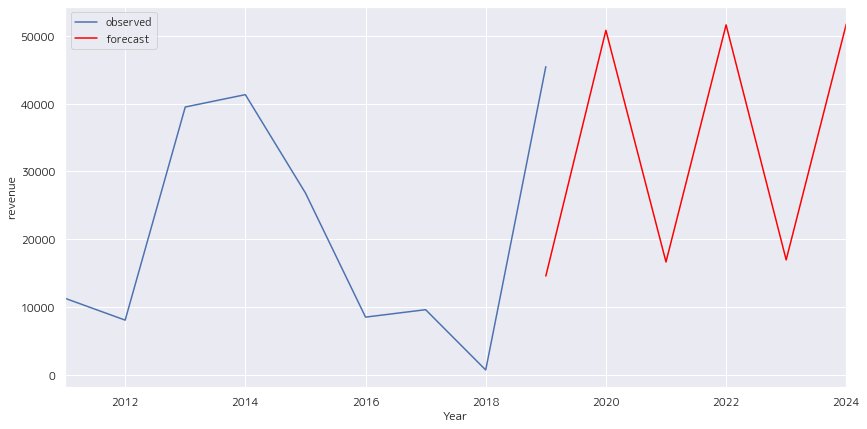

In [308]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023','2024'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [309]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,14557.777398
2020-01-01,50843.372257
2021-01-01,16632.977677
2022-01-01,51645.830133
2023-01-01,16943.279602
2024-01-01,51765.820587


# Engine Model D15B

In [330]:
df_sum_day = df_1g.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_1g.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_1g.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_1g.total_price.values,index=df_1g['Register Date'])

In [331]:
len(train)

65

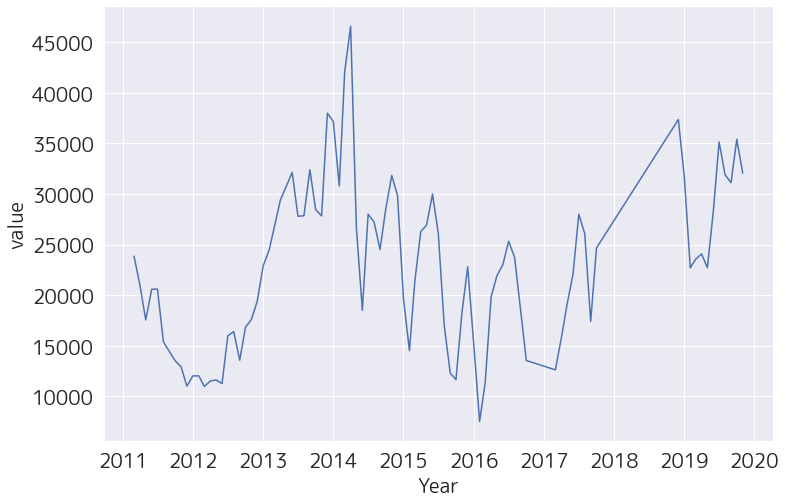

In [332]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [333]:
X = np.log(em_series_month).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=8563.907002, expected=17784.000000
predicted=12598.944140, expected=23826.150000
predicted=14373.333012, expected=26631.280000
predicted=21900.953163, expected=24247.160000
predicted=19913.711848, expected=19864.550000
predicted=21774.249038, expected=10312.190000
predicted=20950.499374, expected=13706.370000
predicted=16254.178418, expected=12758.300000
predicted=15238.314845, expected=23736.850000
predicted=13699.496898, expected=16121.070000
predicted=17763.960543, expected=32307.130000
predicted=16770.007810, expected=31277.850000
predicted=21828.792673, expected=9490.730000
predicted=22272.012157, expected=19383.310000
predicted=18238.193422, expected=50400.250000
predicted=16860.114263, expected=29262.740000
predicted=19446.451409, expected=17836.900000
predicted=24771.799494, expected=25864.310000
predicted=23620.680138, expected=24677.910000
predicted=20294.893826, expected=21095.590000
predicted=19878.398722, expected=23982.990000
predicted=21086.154573, expected=441

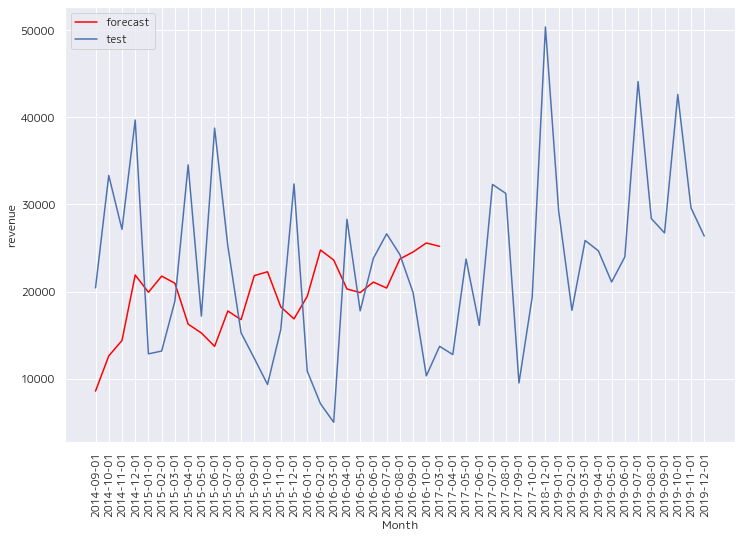

In [334]:
df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][40:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[40:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

In [335]:
import math
min_aic = math.inf
list_param = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic  = results.aic
                list_param.clear()
                list_param.append(param)
                list_param.append(param_seasonal)
print(min_aic,list_param)

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

1314.5323994894927 [(0, 1, 1), (0, 1, 1, 12)]


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [336]:
mod =SARIMAX(em_series_month,
                                order=(5, 0, 1),
                                seasonal_order=(5, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4717      1.196      0.394      0.693      -1.872       2.816
ar.L2         -0.5157      2.408     -0.214      0.830      -5.236       4.204
ar.L3          1.0458      1.655      0.632      0.527      -2.198       4.290
ar.L4         -0.4395      1.883     -0.233      0.815      -4.130       3.251
ar.L5          0.4222      1.627      0.260      0.795      -2.766       3.611
ma.L1          0.8420      0.883      0.954      0.340      -0.888       2.572
ar.S.L12       0.3177      3.398      0.094      0.926      -6.342       6.978
ar.S.L24      -0.2410      0.818     -0.294      0.768      -1.845       1.363
ar.S.L36       0.4695      1.554      0.302      0.763      -2.576       3.515
ar.S.L48      -0.2676      1.302     -0.206      0.837      -2.820       2.284
ar.S.L60       0.2250      1.222      0.184      0.8

D:\Software\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


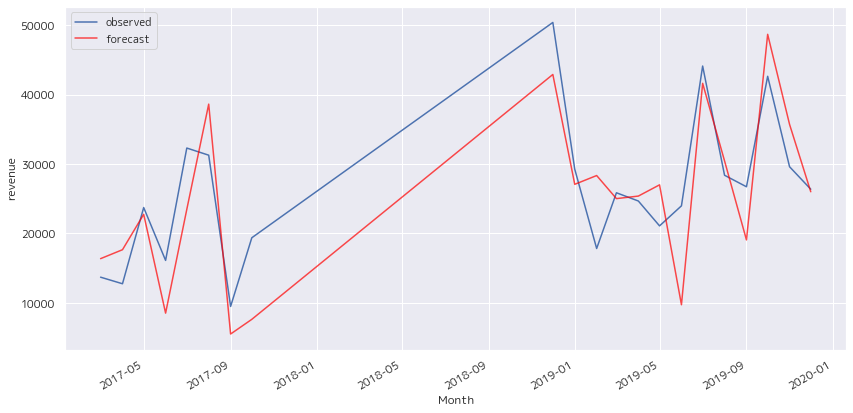

In [337]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [338]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 6652.027
MAPE: 0.245


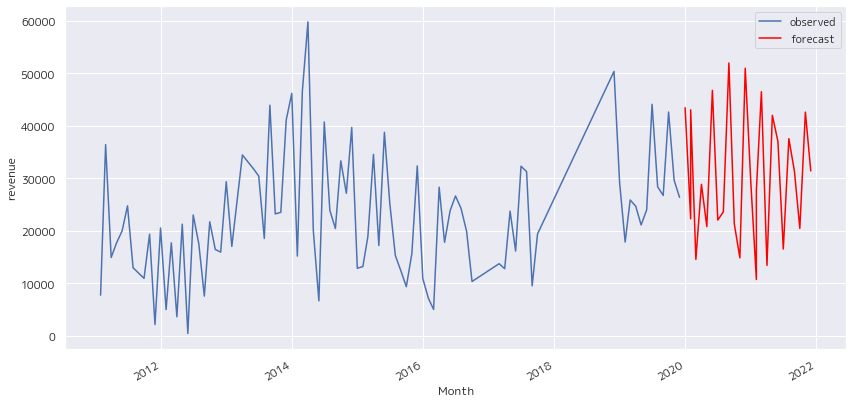

In [339]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [340]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,43473.051426
2020-02-01,22264.775423
2020-03-01,14525.981149
2020-02-01,43068.220792
2020-04-01,28860.905728
2020-05-01,20787.774300
2020-06-01,46774.336658
2020-07-01,22033.738186
2020-08-01,23602.785359
2020-09-01,51996.049064


In [341]:
mod =SARIMAX(em_series_year,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 2),
#                                 order=(1, 0, 1),
#                                 seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3688      2.640     -0.518      0.604      -6.543       3.805
ar.S.L2        0.5840      0.472      1.236      0.216      -0.342       1.510
ma.S.L2        1.2748      0.373      3.419      0.001       0.544       2.006
sigma2      1.752e+10   4.99e-11   3.51e+20      0.000    1.75e+10    1.75e+10


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


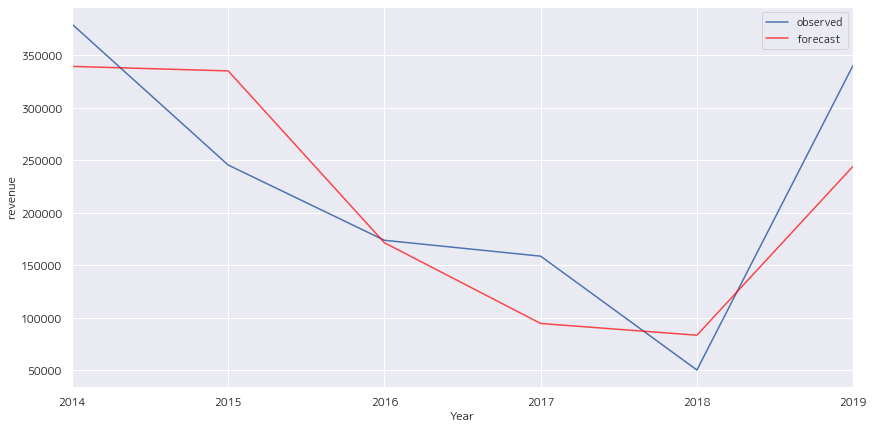

In [342]:
pred = results.get_prediction(start='2014-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2014-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [343]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 63388.864
MAPE: 0.305


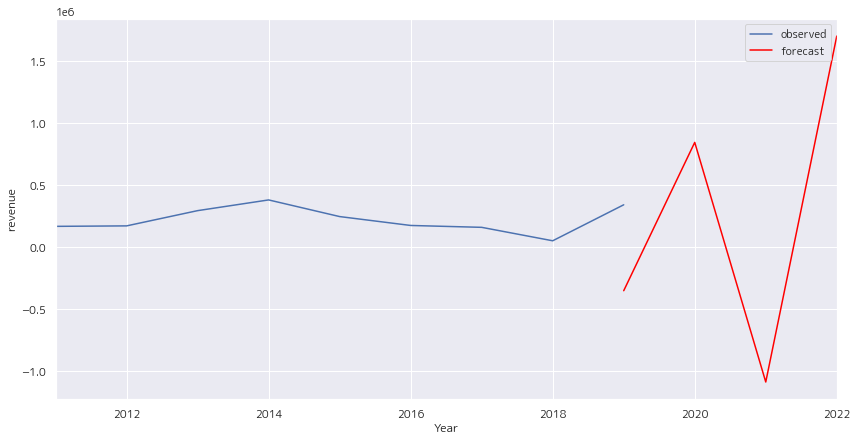

In [344]:
index = pd.to_datetime(['2019', '2020','2021','2022'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [316]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,-3.520534e+05
2020-01-01,8.436314e+05
2021-01-01,-1.088118e+06
2022-01-01,1.700701e+06
2023-01-01,-2.289029e+06


# Engine Model L13A

In [345]:
df_sum_day = df_fp.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_fp.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_fp.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_fp.total_price.values,index=df_fp['Register Date'])

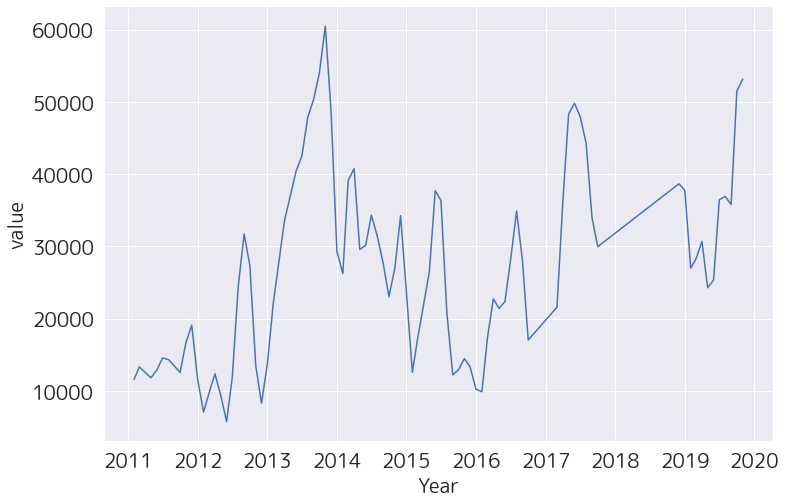

In [346]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [347]:
X = np.log(em_series_month).values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=25285.821398, expected=8093.870000
predicted=15109.933865, expected=22646.390000
predicted=21633.801000, expected=32879.420000
predicted=25812.825692, expected=56744.130000
predicted=22470.761376, expected=46868.280000
predicted=25665.894124, expected=48773.980000
predicted=31097.053750, expected=47389.320000
predicted=36782.748406, expected=33592.290000
predicted=32470.688509, expected=21231.210000
predicted=26375.385282, expected=43776.670000
predicted=32640.362330, expected=45845.970000
predicted=33554.051527, expected=15566.640000
predicted=20324.420599, expected=30945.370000
predicted=26397.076465, expected=35733.890000
predicted=31237.793245, expected=20262.670000
predicted=20910.882638, expected=20813.750000
predicted=21954.550898, expected=39466.280000
predicted=28674.760070, expected=46124.760000
predicted=28368.721068, expected=15926.540000
predicted=20202.308835, expected=65221.450000
predicted=33507.482824, expected=59556.540000
predicted=38074.443693, expected=28

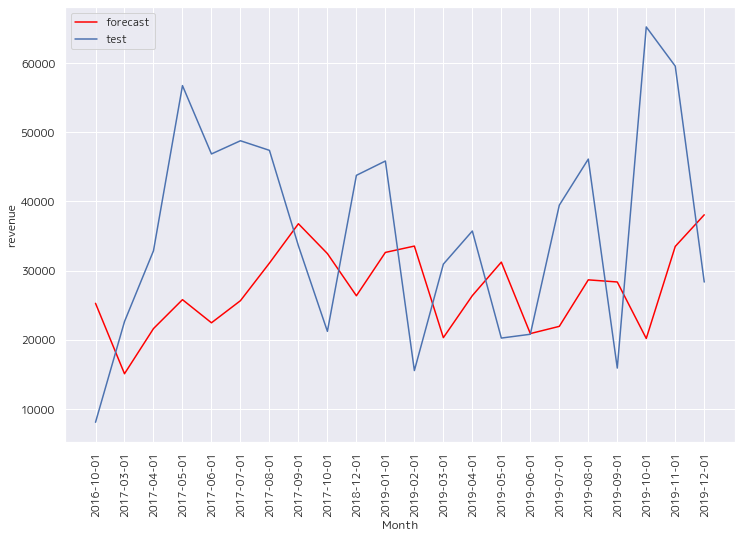

In [348]:
df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

In [349]:
mod =SARIMAX(em_series_month,
                                order=(5, 0, 1),
                                seasonal_order=(5, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1624      2.412      0.067      0.946      -4.566       4.891
ar.L2          0.1193      0.434      0.275      0.783      -0.732       0.970
ar.L3          0.4841      0.401      1.206      0.228      -0.302       1.271
ar.L4          0.5881      1.103      0.533      0.594      -1.573       2.749
ar.L5         -0.3539      1.720     -0.206      0.837      -3.725       3.018
ma.L1         -0.0235      2.986     -0.008      0.994      -5.876       5.829
ar.S.L12      -0.5284      5.151     -0.103      0.918     -10.625       9.568
ar.S.L24       0.0498      0.875      0.057      0.955      -1.665       1.765
ar.S.L36      -0.3063      0.447     -0.686      0.493      -1.182       0.569
ar.S.L48      -0.5724      1.474     -0.388      0.698      -3.462       2.317
ar.S.L60       0.1558      2.318      0.067      0.9

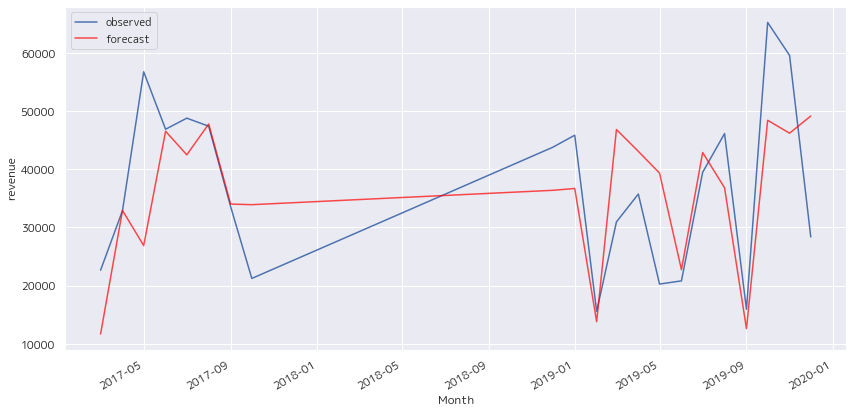

In [350]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [351]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 12012.690
MAPE: 0.272


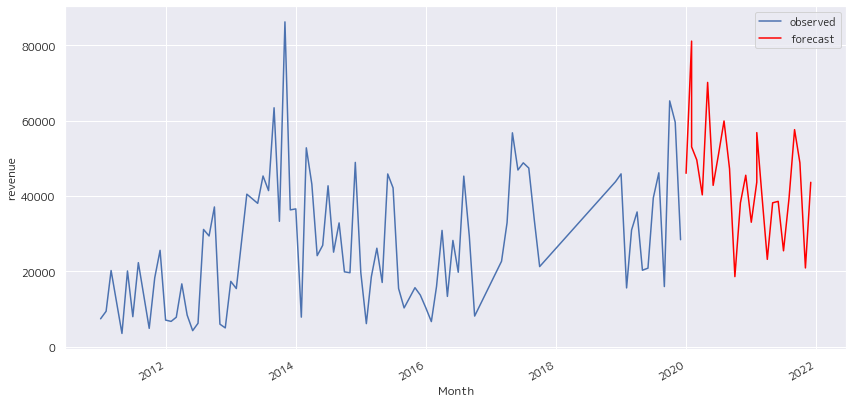

In [352]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [353]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,45994.305185
2020-02-01,81089.067285
2020-03-01,49548.869597
2020-02-01,53017.254209
2020-04-01,40273.764865
2020-05-01,70121.300907
2020-06-01,42797.744352
2020-07-01,51003.165224
2020-08-01,59885.910745
2020-09-01,47199.670346


In [354]:
mod =SARIMAX(em_series_year,
#                                 order=(1, 0, 1),
#                                 seasonal_order=(0, 0, 0, 12),
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0234      0.680      1.506      0.132      -0.308       2.355
ar.S.L2        1.1281      1.265      0.892      0.372      -1.351       3.607
ma.S.L2       -3.7190     20.379     -0.182      0.855     -43.662      36.224
sigma2      3.765e+10   3.69e-10   1.02e+20      0.000    3.77e+10    3.77e+10


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


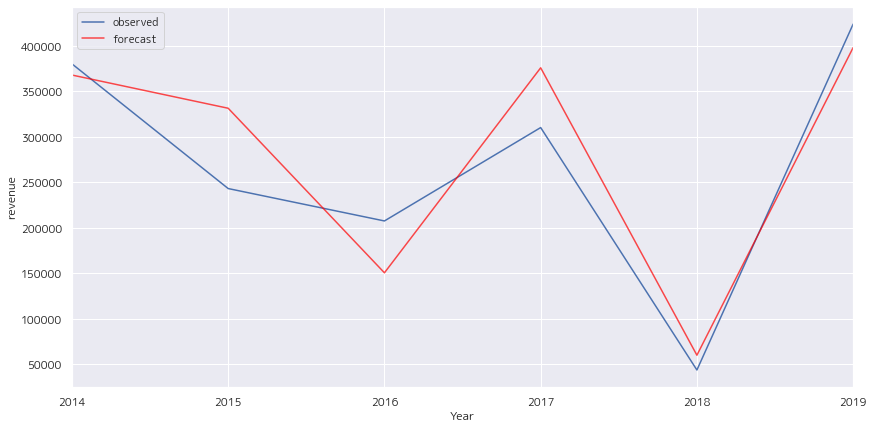

In [355]:
pred = results.get_prediction(start='2014-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2014-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [356]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 52312.640
MAPE: 0.219


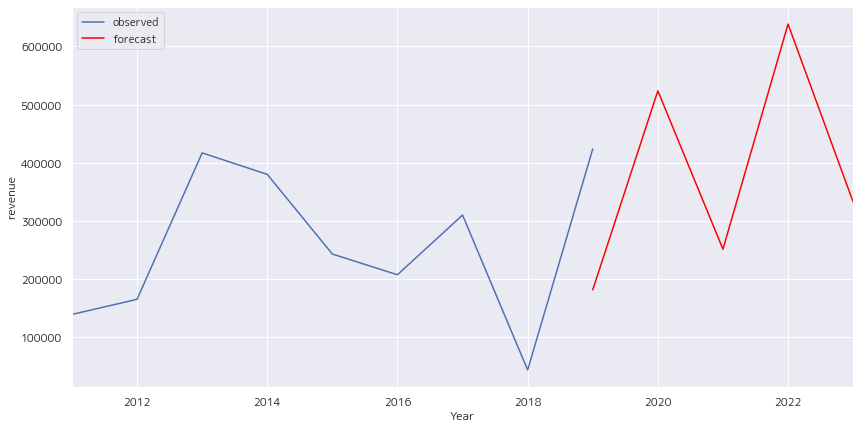

In [357]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [358]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,181618.865701
2020-01-01,523682.558516
2021-01-01,251515.423565
2022-01-01,638488.331049
2023-01-01,332571.012044
